# Import data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

print("Path to dataset files:", path)

c:\Users\marte\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\marte\.cache\kagglehub\datasets\sid321axn\beijing-multisite-airquality-data-set\versions\1


# Imports of libs

In [14]:
import os
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Some notes about the data

The downloaded data includes 12 csv files, seperating observations for each station. So we can stack them on top of each other to work with one csv file

For time series or sequential neural networks, we can filter by station name

- One hot encoding of categorical values (stations) could good!

In [15]:
# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Read each CSV and store in a list
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# Remove 'No' column if exists
if 'No' in df.columns:
    df = df.drop(columns=['No'])

# Save to a single CSV
output_file = os.path.join(path, "beijing_all_stations.csv")
df.to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)

print(f"Combined CSV saved to: {output_file}")
print(f"Shape of combined dataset: {df.shape}")

Combined CSV saved to: C:\Users\marte\.cache\kagglehub\datasets\sid321axn\beijing-multisite-airquality-data-set\versions\1\beijing_all_stations.csv
Shape of combined dataset: (420768, 17)


# Exploratory Data analysis

- Descrition of the beijing air quality dataset:
    - **No**: *row number*
    - **year**: *year of data in this row*
    - **month**: *month of data in this row*
    - **day**: *day of data in this row*
    - **hour**: *hour of data in this row*
    - **PM2.5**: *PM2.5 concentration (ug/m^3)*
    - **PM10**: *PM10 concentration (ug/m^3)*
    - **SO2**: *SO2 concentration (ug/m^3)*
    - **NO2**: *NO2 concentration (ug/m^3)*
    - **CO**: *CO concentration (ug/m^3)*
    - **O3**: *Ozone concentration (ug/m^3)*
    - **TEMP**: *temperature (degree Celsius)*
    - **PRES**: *pressure (hPa)*
    - **DEWP**: *dew point temperature (degree Celsius)*
    - **RAIN**: *precipitation (mm)*
    - **wd**: *wind direction*
    - **WSPM**: *wind speed (m/s)*
    - **station**: *name of the air-quality monitoring site*

### Shape of the data and counts of observations per station

In [ ]:
df.shape
df["station"].value_counts()

station
Aotizhongxin     35064
Changping        35064
Dingling         35064
Dongsi           35064
Guanyuan         35064
Gucheng          35064
Huairou          35064
Nongzhanguan     35064
Shunyi           35064
Tiantan          35064
Wanliu           35064
Wanshouxigong    35064
Name: count, dtype: int64

### Checking the first few rows

In [27]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


### Describing PM2.5

In [25]:

airpoll = df['PM2.5']
print(airpoll.describe())


count    412029.000000
mean         79.793428
std          80.822391
min           2.000000
25%          20.000000
50%          55.000000
75%         111.000000
max         999.000000
Name: PM2.5, dtype: float64


### Checking missing values

In [29]:
print(df.isna().sum())
df.dtypes

year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64


year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object

In [35]:
num_data = df.drop(["station", "wd"], axis = 1)
num_data.corr()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
year,1.000000e+00,-2.020099e-01,-5.569082e-03,-2.115260e-15,-0.025836,-0.037723,-0.170246,-0.056270,0.007861,-0.024384,-0.151791,0.186662,-0.164818,0.000975,0.087472
month,-2.020099e-01,1.000000e+00,1.052232e-02,-1.905981e-16,0.010438,-0.025380,-0.213898,0.042293,0.046648,-0.103691,0.131323,-0.012795,0.265774,0.016066,-0.139666
day,-5.569082e-03,1.052232e-02,1.000000e+00,1.013388e-17,0.003428,0.026015,-0.005146,0.009878,-0.015692,0.002829,0.014390,0.021758,0.023070,-0.003699,-0.011646
hour,-2.115260e-15,-1.905981e-16,1.013388e-17,1.000000e+00,0.011709,0.051426,0.029947,-0.001559,-0.031358,0.282287,0.141983,-0.038367,-0.012216,0.012381,0.140486
PM2.5,-2.583578e-02,1.043824e-02,3.428114e-03,1.170939e-02,1.000000,0.884380,0.482354,0.666948,0.789998,-0.149697,-0.131127,0.018566,0.114656,-0.014359,-0.272205
PM10,-3.772263e-02,-2.537989e-02,2.601467e-02,5.142637e-02,0.884380,1.000000,0.462651,0.652193,0.702363,-0.111294,-0.096209,-0.017971,0.070310,-0.026519,-0.183665
SO2,-1.702462e-01,-2.138978e-01,-5.145818e-03,2.994683e-02,0.482354,0.462651,1.000000,0.499496,0.535750,-0.165341,-0.321799,0.223236,-0.266781,-0.040241,-0.108717
NO2,-5.627017e-02,4.229308e-02,9.877839e-03,-1.558836e-03,0.666948,0.652193,0.499496,1.000000,0.705500,-0.471587,-0.278192,0.174167,-0.031599,-0.043785,-0.400460
CO,7.861472e-03,4.664755e-02,-1.569193e-02,-3.135823e-02,0.789998,0.702363,0.535750,0.705500,1.000000,-0.313012,-0.326237,0.188195,-0.057129,-0.013342,-0.297511
O3,-2.438435e-02,-1.036914e-01,2.829179e-03,2.822873e-01,-0.149697,-0.111294,-0.165341,-0.471587,-0.313012,1.000000,0.594910,-0.445961,0.312074,0.023320,0.295743


### Modify to loop through each station

In [ ]:
numericalData = df.drop(['wd','station'], axis=1)
corr = numericalData.corr() 
s = corr.unstack()
s = s[s.index.get_level_values(0)!=s.index.get_level_values(1)]
strong = s[s.abs() >= 0.3]

pm2_5_corr = strong['PM2.5']
strong = strong[strong.index.get_level_values(0) < strong.index.get_level_values(1)]
strong = [(L0,L1,x)  for x, L0, L1 in zip(strong, strong.index.get_level_values(0), strong.index.get_level_values(1))]
strong

[('PM2.5', 'SO2', 0.4823544617107712),
 ('PM10', 'PM2.5', 0.8843795612854274),
 ('PM10', 'SO2', 0.4626507911881927),
 ('SO2', 'TEMP', -0.32179917743573294),
 ('NO2', 'PM2.5', 0.6669481974591158),
 ('NO2', 'PM10', 0.6521926021257819),
 ('NO2', 'SO2', 0.4994956387327588),
 ('NO2', 'O3', -0.4715868114241119),
 ('NO2', 'WSPM', -0.4004597048299562),
 ('CO', 'PM2.5', 0.7899978240028879),
 ('CO', 'PM10', 0.7023628006274567),
 ('CO', 'SO2', 0.5357504895318288),
 ('CO', 'NO2', 0.7054995244594816),
 ('CO', 'O3', -0.31301244424630953),
 ('CO', 'TEMP', -0.32623652876393855),
 ('O3', 'TEMP', 0.5949100626924623),
 ('O3', 'PRES', -0.44596060280670025),
 ('PRES', 'TEMP', -0.813309481039967),
 ('DEWP', 'O3', 0.31207382058250244),
 ('DEWP', 'TEMP', 0.8201180266857427),
 ('DEWP', 'PRES', -0.7502221671407476)]

In [71]:
pm2_5_corr

PM10    0.879104
SO2     0.481025
NO2     0.684986
CO      0.785006
dtype: float64

In [102]:
def t_test(group_vector1, group_vector2):
    equal_var_=np.var(group_vector1,ddof=1)==np.var(group_vector2,ddof=1)
    res=stats.ttest_ind(group_vector1,group_vector2, equal_var=equal_var_)
    return res

In [ ]:
def diagnose_mv(df, mv_column):
    df_no_null = df[df[mv_column].notnull()]
    df_is_null=df[df[mv_column].isnull()]
    for col in df.columns:
        sAll = pd.to_numeric(df[col], errors='coerce')
        sNonnull = pd.to_numeric(df_no_null[col].dropna(), errors='coerce')
        missing= pd.to_numeric(df_is_null[col].dropna(), errors='coerce')
        results, p=t_test(sNonnull,missing)
        print("mcar" if p>0.5 else "not mcar")
        if pd.api.types.is_numeric_dtype(df[col]):

            bins = np.histogram_bin_edges(sAll.dropna())

            countsAll, _   = np.histogram(sAll,    bins=bins)
            countsNonnull, _ = np.histogram(sNonnull, bins=bins)
            diff = np.abs(countsAll - countsNonnull)
            missingness= diff/countsAll
            data=np.vstack([diff, countsNonnull]).T
            '''
            if col != mv_column:
                chi2, p, dof, expected = chi2_contingency(data)
                print("Chi2 statistic:", chi2)
                print("degree of freedom: ",dof)
                print("p-value:", p)
            ''' 
            print(missingness*100)
            # plot
            fig, axes = plt.subplots(1, 3, figsize=(8, 2))

            bin_centers = 0.5 * (bins[1:] + bins[:-1])
            bin_widths  = np.diff(bins)

            axes[0].hist(sAll,    bins=bins)
            axes[1].hist(sNonnull.dropna(), bins=bins)
            axes[2].bar(bin_centers, diff, width=bin_widths, alpha=0.3, align='center')

            for ax in axes:
                ax.set_xticks(bin_centers)
                ax.set_xticklabels(bin_centers.astype(int))

            axes[0].set_title(f"{col} — all")
            axes[1].set_title(f"{col} — without MV")
            axes[2].set_title("|Δ count| per bin")
            plt.tight_layout()
            plt.show()

        else:

            vc_all = df[col].value_counts(dropna=False) #seriese of bin counts
            vc_non = df_no_null[col].value_counts(dropna=False)

            # align categories incase one category have no values, so diff do not return error
            cats = vc_all.index.union(vc_non.index) #
            c_all = vc_all.reindex(cats, fill_value=0)
            c_non = vc_non.reindex(cats, fill_value=0)
            diff = (c_all - c_non).abs()
            missingness= diff/c_all
            '''
            data=np.vstack([diff, c_non]).T
            if col != mv_column:
                chi2, p, dof, expected = chi2_contingency(data)
                print("Chi2 statistic:", chi2)
                print("degree of freedom: ",dof)
                print("p-value:", p)
            '''
            print("missingness ",missingness*100)
            x = np.arange(len(cats)) # number of categories/ bins
           
            w = 0.8

            fig, axes = plt.subplots(1, 3, figsize=(8, 2))

            axes[0].bar(x, c_all.values, width=w)
            axes[1].bar(x, c_non.values, width=w)
            axes[2].bar(x, diff.values,  width=w, alpha=0.3)


            for ax in axes:
                ax.set_xticks(x)
                ax.set_xticklabels(cats.astype(str), rotation=45, ha='right')

            axes[0].set_title(f"{col} — all")
            axes[1].set_title(f"{col} — without MV")
            axes[2].set_title("|Δ count| per category")
            plt.tight_layout()
            plt.show()



In [73]:


missing=[df.isna().sum()]
missing


[year          0
 month         0
 day           0
 hour          0
 PM2.5       925
 PM10        718
 SO2         935
 NO2        1023
 CO         1776
 O3         1719
 TEMP         20
 PRES         20
 DEWP         20
 RAIN         20
 wd           81
 WSPM         14
 station       0
 dtype: int64]

TtestResult(statistic=np.float64(0.22514305253984318), pvalue=np.float64(0.8219130081932269), df=np.float64(1021.7818040588945))
[0.14978214        nan 5.76484018        nan        nan 2.46575342
        nan 2.01502732        nan 1.1299435 ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1118359484.py:16: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


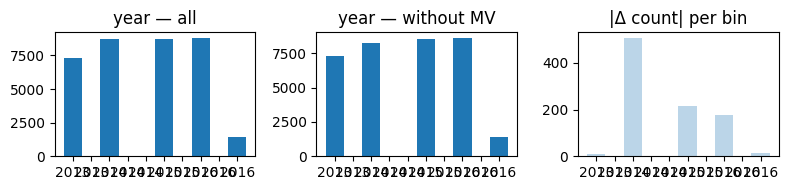

TtestResult(statistic=np.float64(-13.810738678272855), pvalue=np.float64(1.0017760273935468e-39), df=np.float64(965.8341383410024))
[1.23066104 1.74731183 4.82638889 0.73924731 1.90972222 1.51209677
 2.28494624 1.38888889 1.17607527 6.81352459]


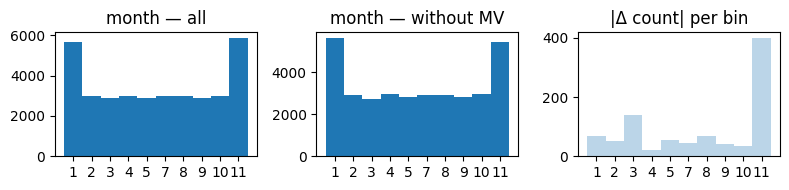

TtestResult(statistic=np.float64(-11.110328357136694), pvalue=np.float64(4.362471201106247e-27), df=np.float64(975.1412840470462))
[2.45949074 0.63657407 1.70717593 2.77777778 0.92592593 2.31481481
 3.3275463  3.03819444 5.15046296 3.86363636]


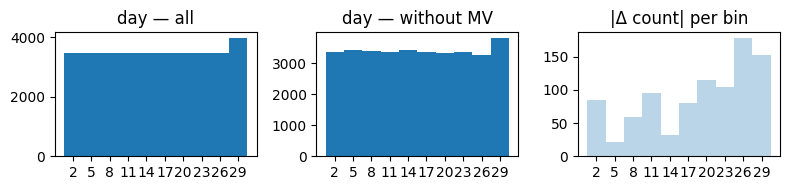

TtestResult(statistic=np.float64(-1.5823704910301302), pvalue=np.float64(0.11388697479074018), df=np.float64(982.1134690599869))
[2.16746521 2.42984257 2.08761123 2.41843486 3.28542094 3.21697467
 3.42231348 2.97741273 2.46406571 2.12183436]


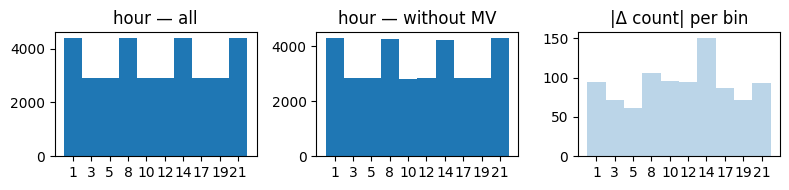

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))
[ 0.  0.  0.  0.  0.  0.  0.  0. nan  0.]


C:\Users\yohan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1118359484.py:16: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


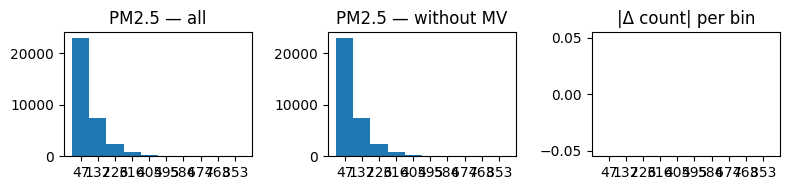

TtestResult(statistic=np.float64(-0.5561778781870251), pvalue=np.float64(0.5786621821863553), df=np.float64(217.04518755611872))
[0.625323   0.56956876 0.79073708 0.36036036 0.97402597 1.49253731
 4.44444444 0.         0.         0.        ]


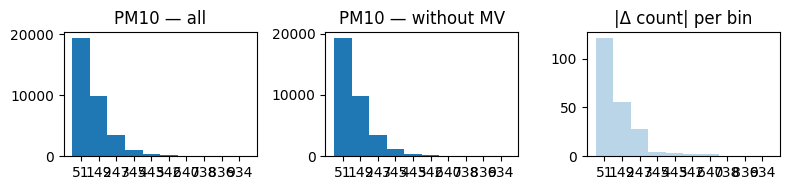

TtestResult(statistic=np.float64(5.302977276038782), pvalue=np.float64(2.3144256487045875e-07), df=np.float64(280.2164524631583))
[0.86351643 0.48906789 0.19704433 0.         0.86206897 0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1118359484.py:16: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


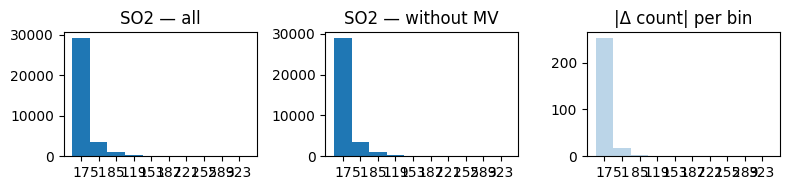

TtestResult(statistic=np.float64(5.816816125697728), pvalue=np.float64(1.6954855183105655e-08), df=np.float64(269.4880563140909))
[1.10234393 0.94222899 0.50219711 0.52154195 0.23980815 0.33557047
 0.97087379 0.         0.         0.        ]


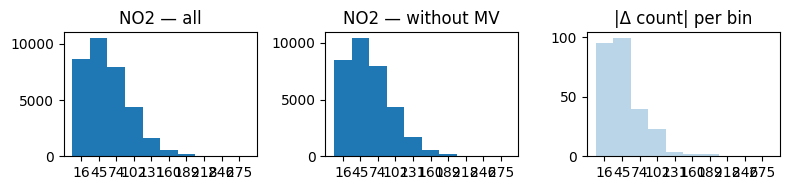

TtestResult(statistic=np.float64(6.616578097389819), pvalue=np.float64(1.9320384789618942e-10), df=np.float64(273.32504180386155))
[0.8981435  0.77925396 0.71843996 0.07905138 0.1540832  0.
 0.         0.9009009  0.         0.        ]


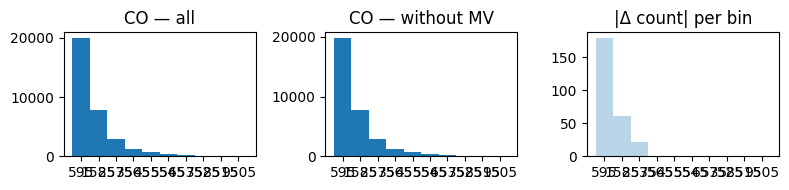

TtestResult(statistic=np.float64(-5.23431685603507), pvalue=np.float64(3.278779225177318e-07), df=np.float64(276.67948420956054))
[0.53223299 0.93619972 1.55651341 1.05379922 0.73868883 1.70542636
 0.         0.         0.         0.        ]


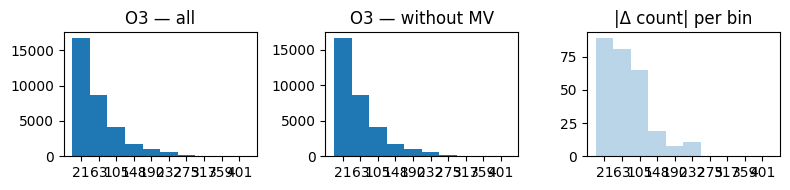

TtestResult(statistic=np.float64(8.892135651020308), pvalue=np.float64(2.864737227953917e-18), df=np.float64(972.3221268728142))
[1.51515152 3.04347826 4.60224906 3.46399271 2.29830022 2.16001763
 1.68513029 2.22183649 1.94924605 1.19047619]


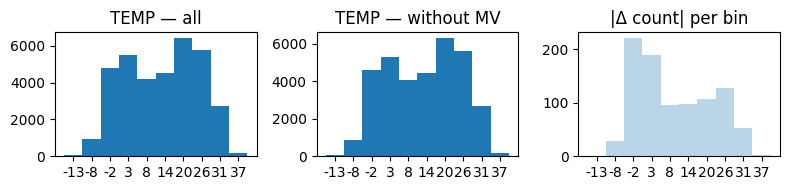

TtestResult(statistic=np.float64(-10.518326402737435), pvalue=np.float64(1.4116005018389303e-24), df=np.float64(969.7712463509845))
[2.5        2.39410681 2.01860628 1.08427797 1.86947655 3.08163633
 4.06061784 5.08062063 3.01274623 2.56410256]


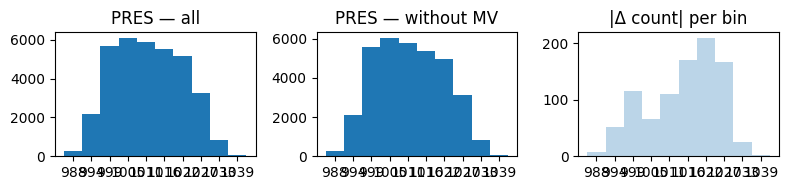

TtestResult(statistic=np.float64(11.770162386515082), pvalue=np.float64(5.431720752392946e-30), df=np.float64(971.3442285791806))
[1.75438596 5.23952096 4.31759971 4.75959203 3.3312896  1.71530408
 2.66250899 1.50390253 1.23401725 3.19917441]


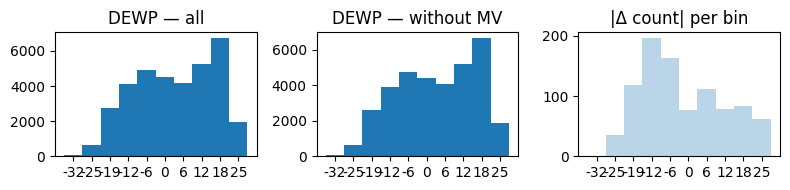

TtestResult(statistic=np.float64(3.4181756434933943), pvalue=np.float64(0.0006513689537196938), df=np.float64(1210.9987287705978))
[2.641736   2.56410256 0.         0.         0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1118359484.py:16: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


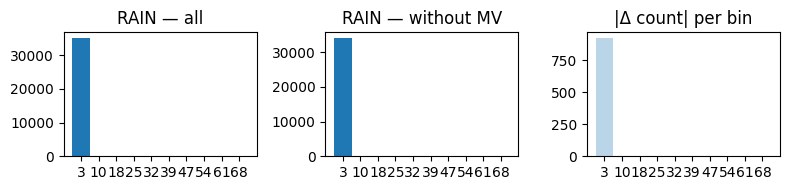

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))
missingness  wd
NE     2.490272
ENE    2.607595
SW     2.262578
E      2.684049
NNE    2.576687
WSW    2.983725
SSW    2.192564
N      3.000968
NW     3.225806
ESE    1.688992
NNW    4.782882
SE     2.162565
S      1.917178
W      2.134927
WNW    3.088102
SSE    3.228963
NaN    0.000000
Name: count, dtype: float64


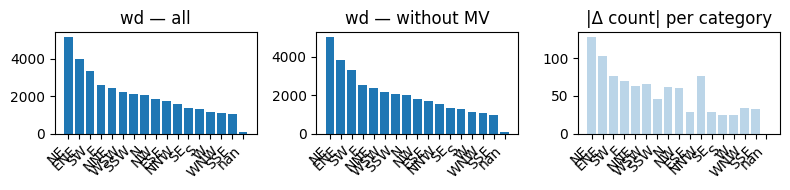

TtestResult(statistic=np.float64(-4.698281327998755), pvalue=np.float64(3.003969953228773e-06), df=np.float64(965.5112282879587))
[2.44973423 2.40928019 2.97500992 3.13179643 5.08474576 4.37710438
 3.84615385 0.         0.         0.        ]


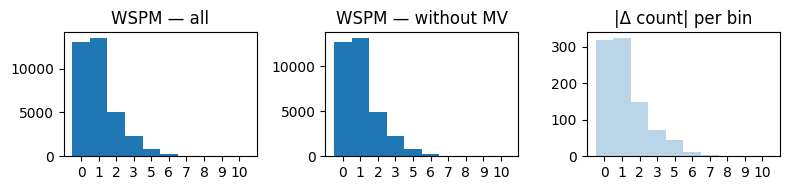

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))
missingness  station
Aotizhongxin    2.638033
Name: count, dtype: float64


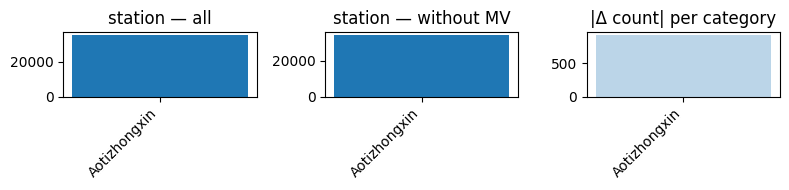

In [104]:
diagnose_mv(df, 'PM2.5')

[0.06808279        nan 5.55936073        nan        nan 1.14155251
        nan 1.2636612         nan 1.05932203]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


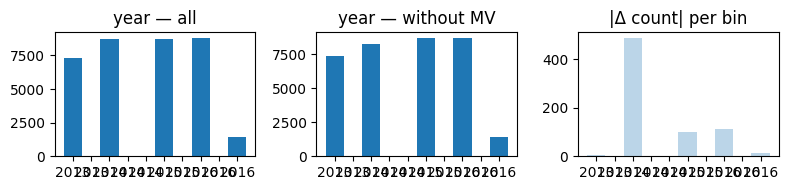

[1.12517581 1.07526882 2.91666667 0.50403226 0.83333333 1.47849462
 0.67204301 1.18055556 0.67204301 6.50614754]


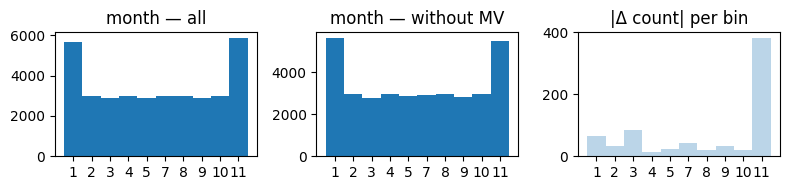

[0.86805556 0.54976852 1.04166667 1.12847222 0.83912037 2.02546296
 2.60416667 2.63310185 4.86111111 3.68686869]


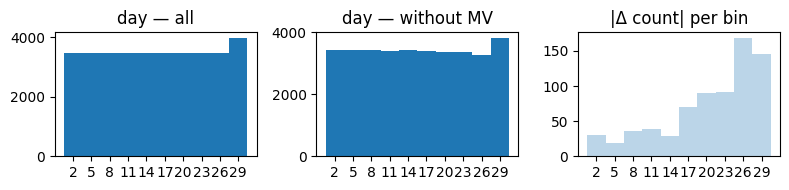

[1.75678759 1.98494182 1.64271047 1.82523386 2.73785079 2.63518138
 2.41843486 2.15605749 1.95071869 1.64271047]


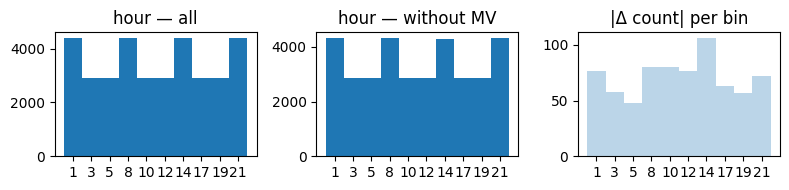

[2.18083482e-02 2.67701780e-02 4.03225806e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
            nan 1.00000000e+02]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


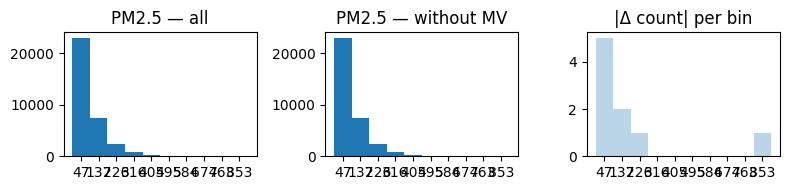

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


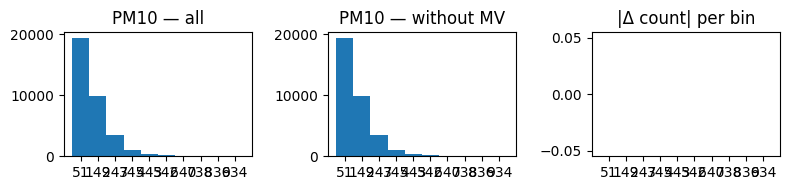

[  0.2021725    0.1726122    0.19704433   0.           0.86206897
   0.           0.                  nan          nan 100.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


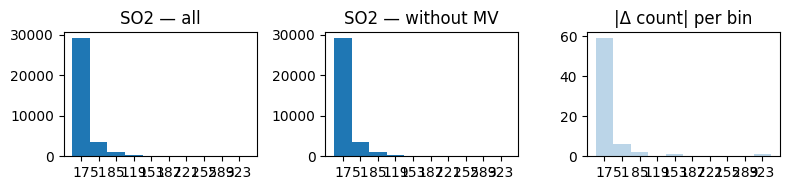

[0.31329775 0.23793661 0.05021971 0.1814059  0.         0.16778523
 0.         0.         0.         0.        ]


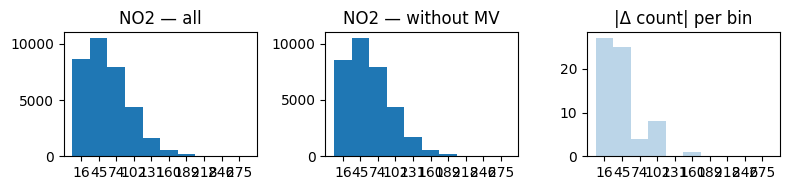

[0.23582539 0.12774655 0.30790284 0.         0.1540832  0.
 0.         0.         0.         0.        ]


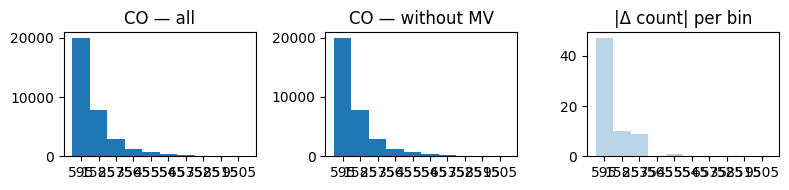

[0.12558306 0.25427647 0.52681992 0.27731559 0.18467221 0.93023256
 0.         0.         0.         0.        ]


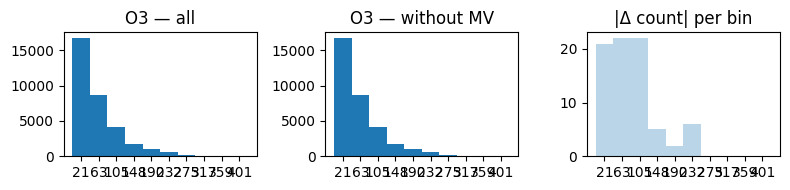

[1.51515152 2.93478261 4.41482716 3.02643573 1.72372516 1.52082874
 0.95178655 1.19770873 1.50790732 0.        ]


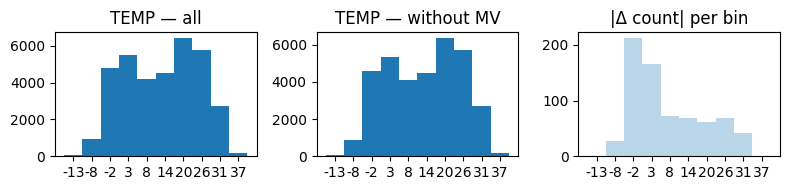

[2.14285714 1.01289134 1.24626997 0.44356826 1.20666213 2.79329609
 3.80804352 4.32004868 3.01274623 2.56410256]


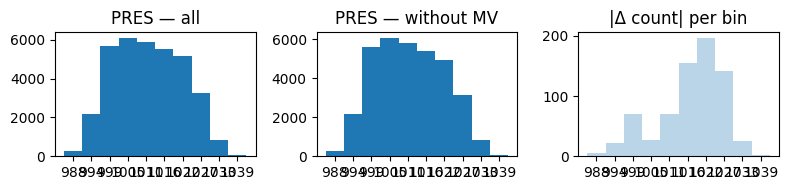

[1.75438596 3.14371257 3.84193194 4.56532297 2.84079297 1.15838717
 1.51115375 1.00894727 1.07047279 1.23839009]


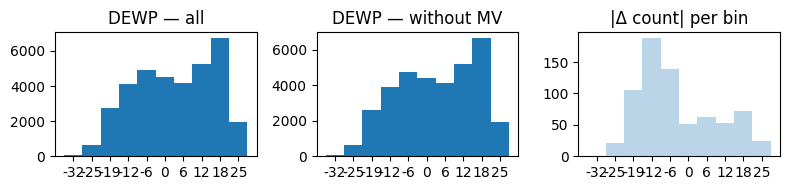

[2.05277754 0.         0.         0.         0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


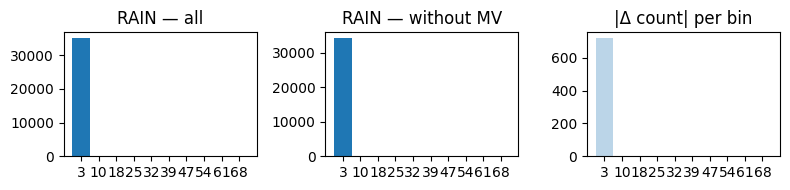

missingness  wd
NE     2.373541
ENE    2.253165
SW     1.607621
E      1.878834
NNE    2.249489
WSW    2.034358
SSW    1.620591
N      2.662149
NW     2.150538
ESE    1.281305
NNW    3.964758
SE     1.416853
S      0.996933
W      1.622545
WNW    2.089010
SSE    1.565558
NaN    0.000000
Name: count, dtype: float64


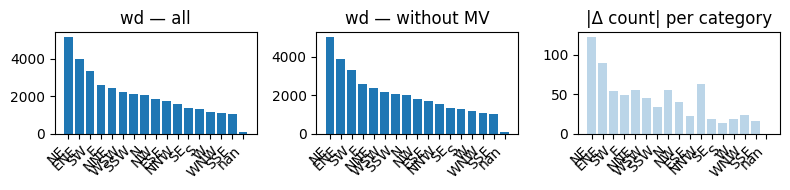

[2.09537016 1.83670434 2.22134074 2.08786429 2.82485876 3.7037037
 2.56410256 5.88235294 0.         0.        ]


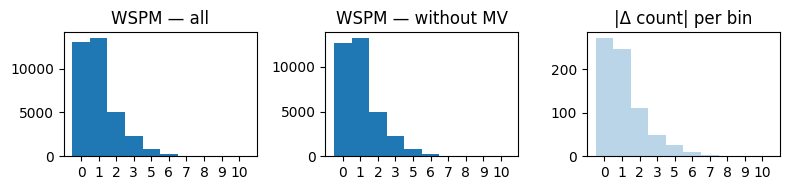

missingness  station
Aotizhongxin    2.047684
Name: count, dtype: float64


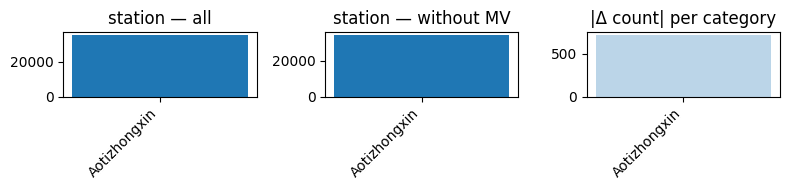

In [75]:
diagnose_mv(df, 'PM10')

[1.37527233        nan 6.54109589        nan        nan 1.23287671
        nan 1.52550091        nan 1.34180791]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


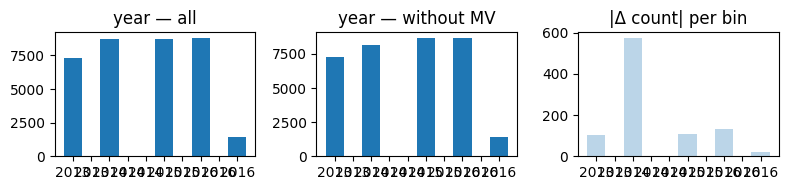

[1.35372714 1.31048387 2.8125     0.73924731 1.14583333 1.47849462
 1.07526882 2.29166667 2.72177419 7.85519126]


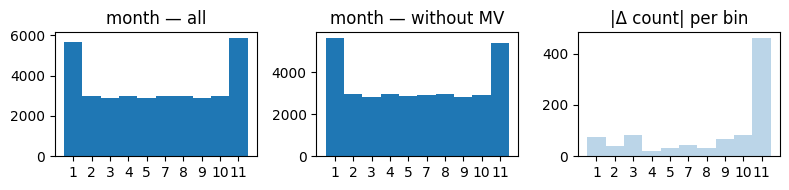

[0.86805556 0.66550926 1.07060185 2.71990741 1.07060185 2.05439815
 2.9224537  2.9224537  5.84490741 6.03535354]


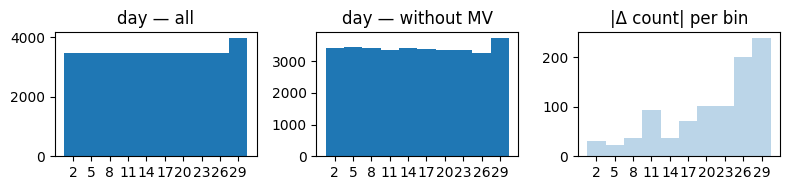

[2.92037417 2.49828884 2.3613963  2.28154232 3.55920602 3.31964408
 2.71503536 2.77207392 2.39561944 2.14464978]


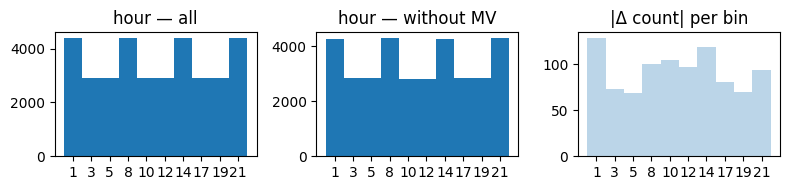

[0.85052558 0.56217374 0.64516129 2.43055556 0.42372881 6.14035088
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


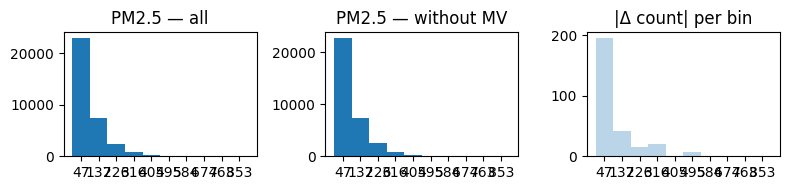

[0.88888889 0.68144833 0.64953403 1.35135135 1.94805195 2.23880597
 0.         0.         0.         0.        ]


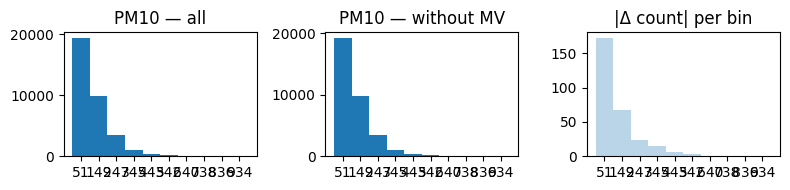

[ 0.  0.  0.  0.  0.  0.  0. nan nan  0.]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


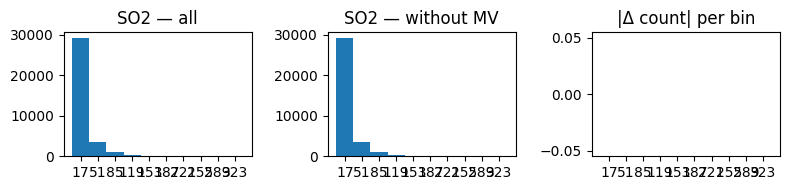

[0.55697378 0.43780337 0.55241682 0.430839   0.29976019 0.33557047
 0.97087379 0.         0.         0.        ]


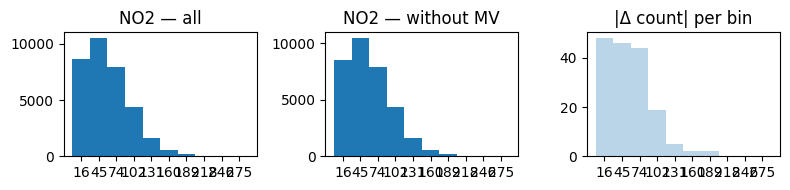

[0.44656297 0.38323965 0.47895997 0.4743083  0.1540832  0.95238095
 0.         0.         3.125      0.        ]


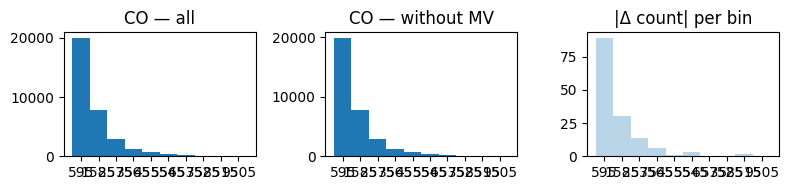

[0.5860543  0.56634304 0.83812261 0.72102052 0.18467221 0.46511628
 0.         0.         0.         0.        ]


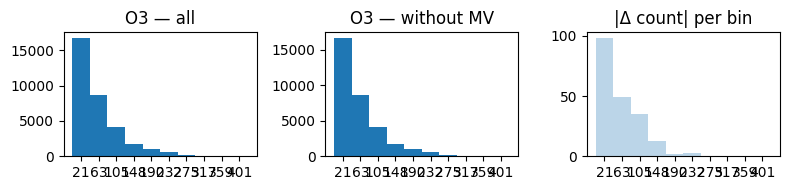

[1.51515152 4.34782609 5.26863807 3.64630811 2.22647833 2.71104254
 1.51349665 1.3886478  1.76535491 0.        ]


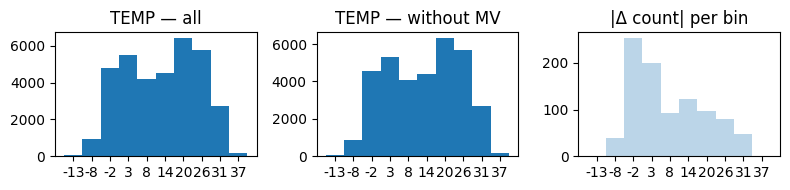

[1.07142857 1.05893186 1.59733193 0.73928043 1.66553365 4.16291224
 5.10977268 4.65470033 3.01274623 2.56410256]


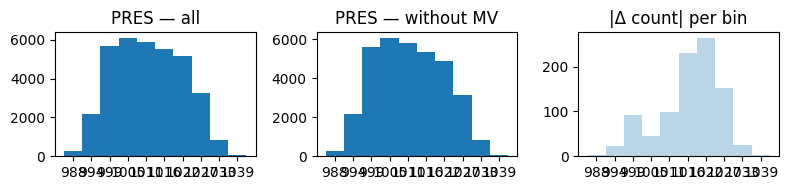

[1.75438596 2.54491018 5.59824369 5.22098106 2.98385449 2.27222098
 2.11081794 1.71330668 1.44216473 1.34158927]


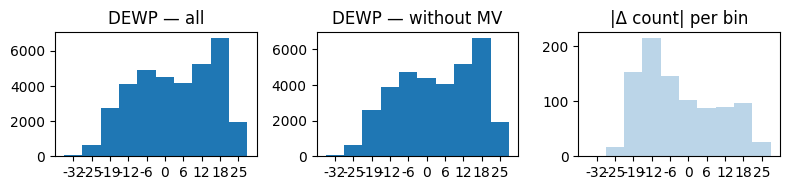

[2.67318524 0.         0.         0.         0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


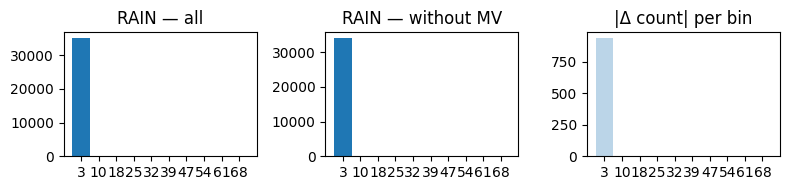

missingness  wd
NE     3.287938
ENE    2.860759
SW     2.322120
E      2.377301
NNE    2.985685
WSW    2.576854
SSW    1.906578
N      3.291384
NW     2.849462
ESE    1.514269
NNW    4.782882
SE     1.715138
S      1.380368
W      2.732707
WNW    2.543143
SSE    1.859100
NaN    0.000000
Name: count, dtype: float64


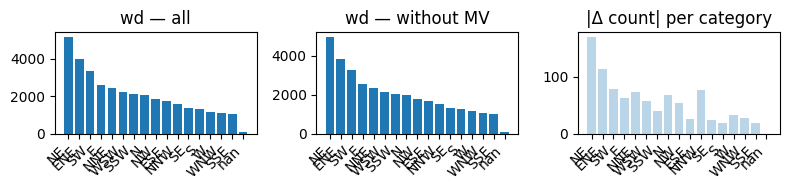

[2.90424467 2.38697204 2.91550972 2.3923445  3.05084746 2.35690236
 1.28205128 0.         0.         0.        ]


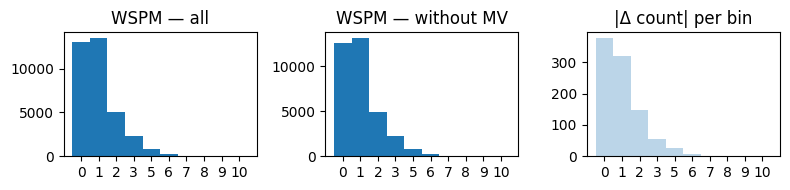

missingness  station
Aotizhongxin    2.666553
Name: count, dtype: float64


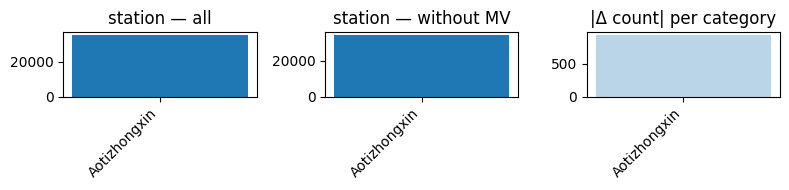

In [76]:
diagnose_mv(df, 'SO2')

[0.66721133        nan 7.00913242        nan        nan 1.34703196
        nan 2.53870674        nan 1.34180791]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


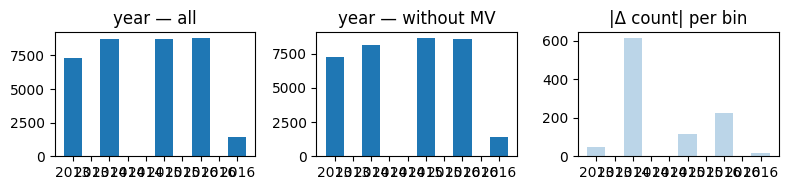

[1.96905767 1.20967742 3.15972222 1.00806452 1.11111111 1.74731183
 2.01612903 3.05555556 3.52822581 7.12090164]


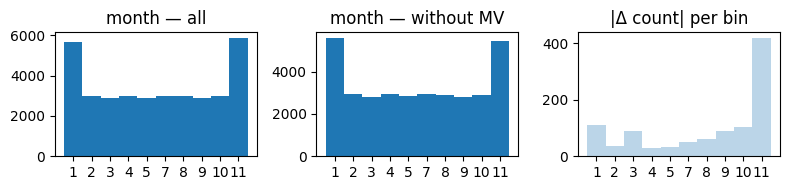

[1.24421296 1.07060185 1.59143519 3.3275463  1.38888889 2.48842593
 3.18287037 3.06712963 6.07638889 5.37878788]


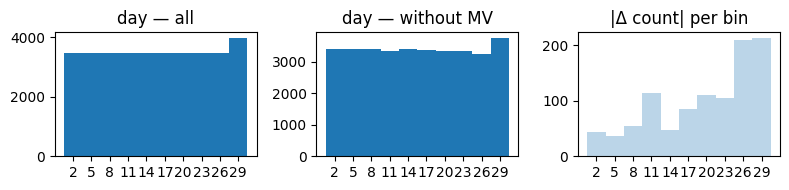

[3.62765229 3.11430527 3.21697467 2.50969655 3.42231348 2.97741273
 3.08008214 3.01163587 2.32717317 2.07620351]


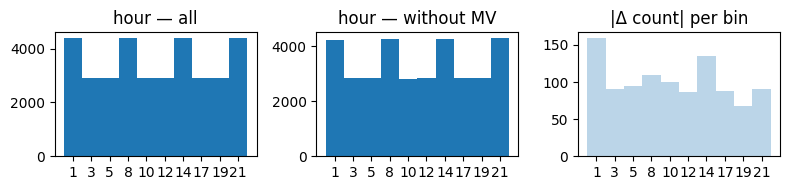

[0.99446068 0.9771115  1.20967742 2.66203704 2.11864407 3.50877193
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


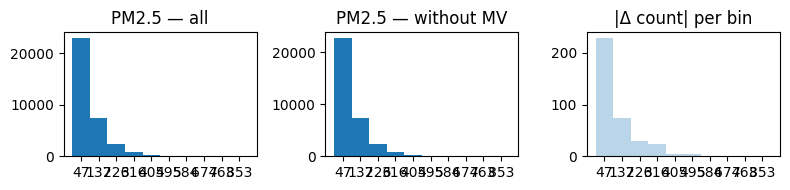

[1.06459948 0.90520749 1.29906806 1.71171171 1.94805195 2.23880597
 2.22222222 0.         0.         0.        ]


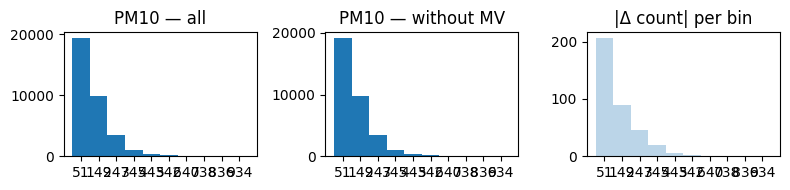

[0.71959703 1.00690449 0.78817734 0.31847134 0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


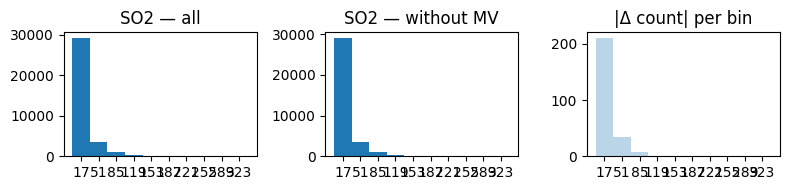

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


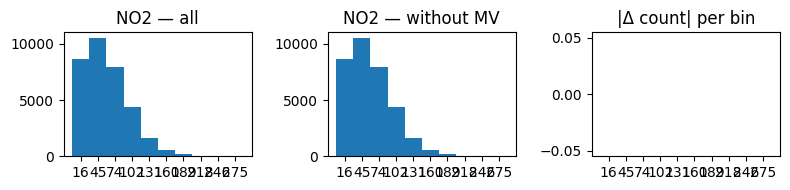

[0.64224787 0.80480327 1.06055423 0.9486166  1.38674884 0.95238095
 1.18343195 0.         0.         0.        ]


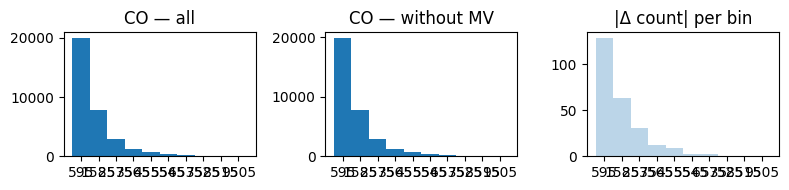

[1.07044612 0.65880721 0.62260536 0.72102052 0.27700831 0.93023256
 0.4784689  0.         0.         0.        ]


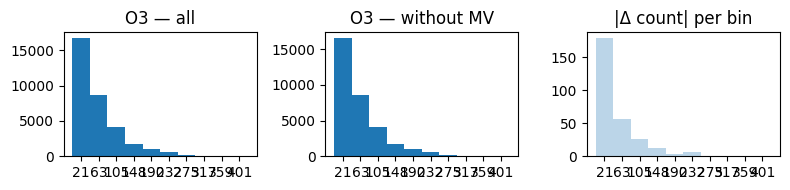

[1.51515152 4.23913043 5.22698875 3.53691887 2.60952837 3.26206745
 1.99719145 1.82260024 1.76535491 0.        ]


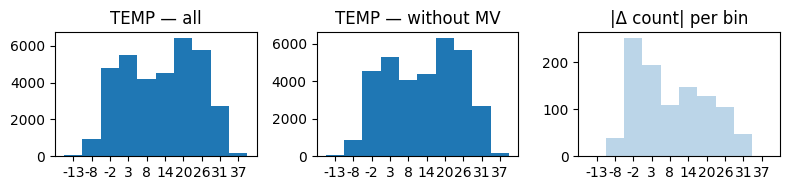

[1.42857143 1.97974217 1.72020362 1.14999179 1.58055744 4.1809335
 5.38177579 5.38484941 3.12862109 2.56410256]


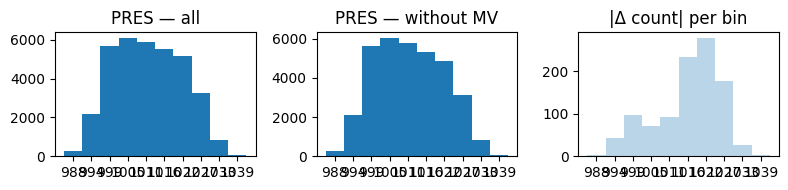

[1.75438596 2.84431138 4.86644713 4.9538611  3.31085224 2.65092448
 2.27872391 2.53188654 1.73951829 2.06398349]


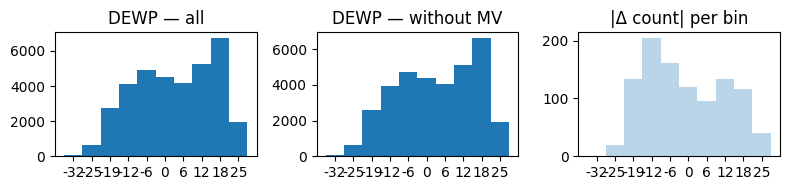

[2.92192012 2.56410256 0.         0.         0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


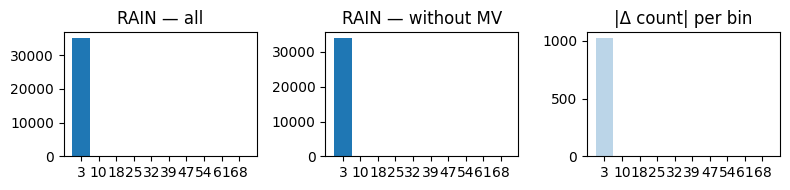

missingness  wd
NE     3.910506
ENE    3.518987
SW     2.203037
E      2.799080
NNE    3.558282
WSW    2.396022
SSW    2.383222
N      3.242982
NW     2.580645
ESE    1.688992
NNW    4.782882
SE     2.460850
S      1.380368
W      2.391119
WNW    2.633969
SSE    1.761252
NaN    0.000000
Name: count, dtype: float64


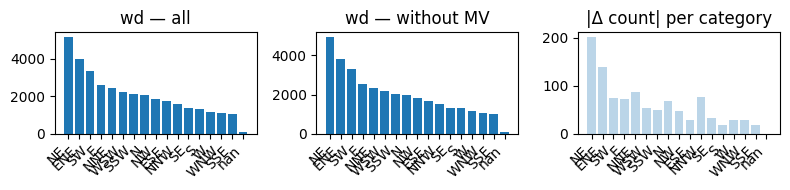

[3.3125337  2.61005354 2.93534312 2.3923445  3.50282486 2.35690236
 1.28205128 0.         0.         0.        ]


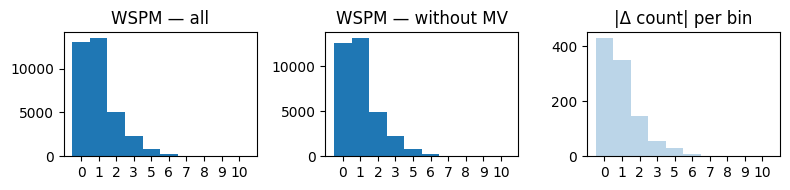

missingness  station
Aotizhongxin    2.917522
Name: count, dtype: float64


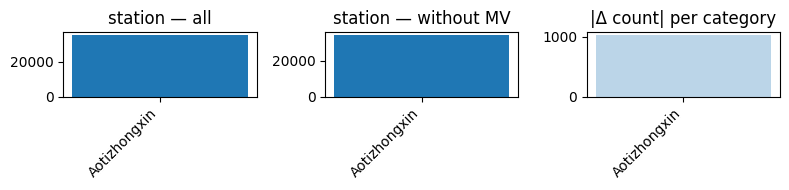

In [77]:
diagnose_mv(df, 'NO2')

[11.76470588         nan  6.67808219         nan         nan  1.88356164
         nan  1.4571949          nan  2.40112994]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


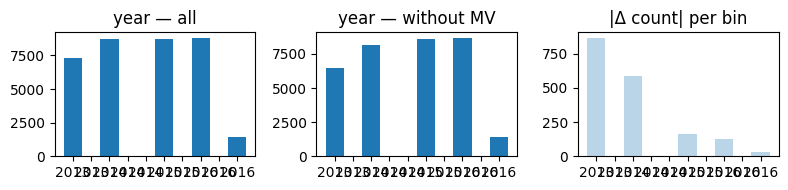

[ 1.91631505  3.62903226  4.375       3.56182796  8.15972222  2.65456989
  6.1827957   2.60416667  4.60349462 10.53620219]


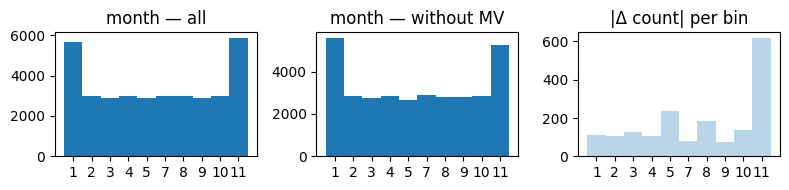

[2.45949074 2.28587963 3.125      4.97685185 2.83564815 5.09259259
 7.08912037 8.24652778 8.82523148 5.63131313]


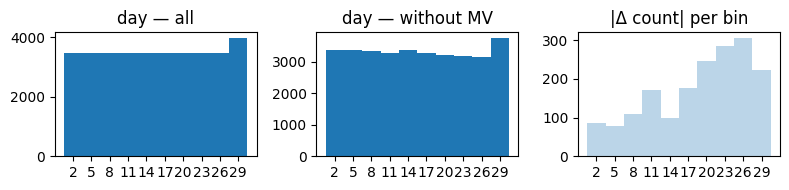

[4.5174538  6.50239562 4.6201232  4.95094684 5.47570157 5.92060233
 5.2019165  5.03080082 4.75701574 4.31211499]


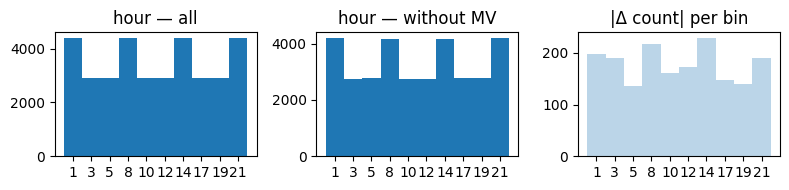

[ 3.30614559  2.78409851  2.45967742  3.81944444  4.23728814 18.42105263
 58.82352941 33.33333333         nan  0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


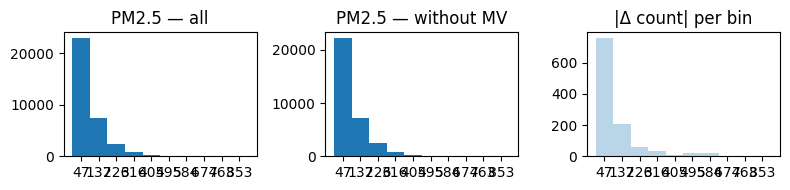

[ 3.11627907  3.16314076  3.53007625  2.25225225  4.54545455 19.40298507
 40.          0.          7.14285714 66.66666667]


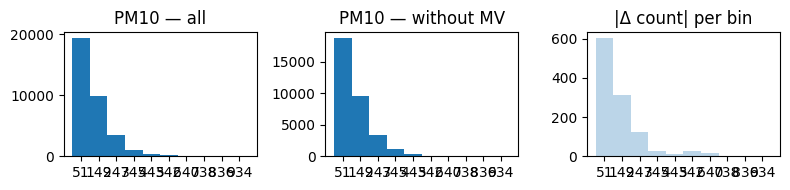

[2.741322   3.65362486 4.2364532  4.45859873 1.72413793 0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


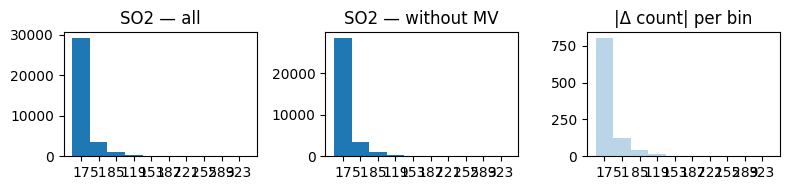

[ 2.10025528  3.35966499  3.46516008  2.40362812  2.15827338  2.51677852
 12.13592233 16.66666667  0.          0.        ]


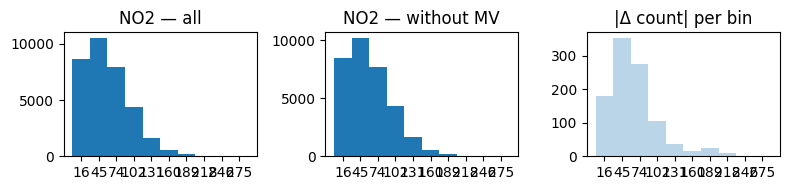

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


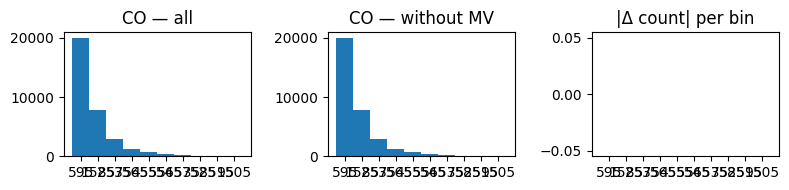

[ 2.37411793  2.19602404  2.5862069   3.77149196  4.06278855  3.25581395
  3.3492823   4.65116279 22.22222222  0.        ]


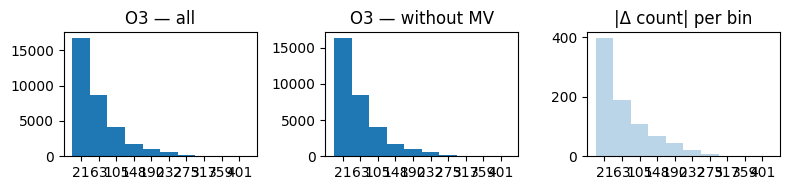

[1.51515152 7.17391304 7.85089546 5.08659982 3.44745032 4.36411726
 4.19722266 5.22478736 4.92828246 4.16666667]


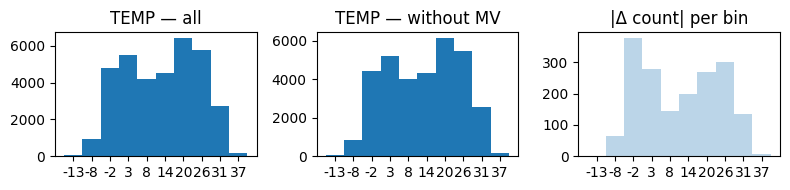

[12.85714286 10.95764273  4.33561524  2.72712338  2.51529572  6.16327266
  6.29492908  7.3319136   3.70799537  2.56410256]


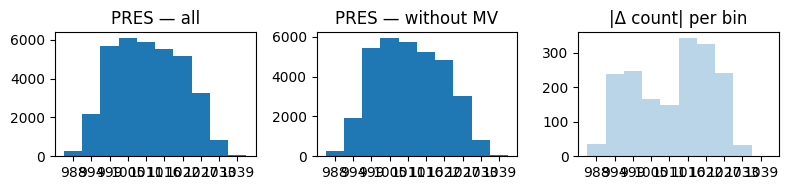

[1.75438596 2.69461078 6.69593853 8.40213696 4.57796853 3.65337492
 4.10170305 2.87454788 5.64971751 7.12074303]


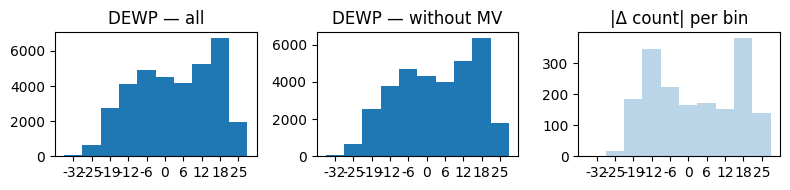

[  5.07476342   0.           0.           0.           0.
   0.           0.                  nan          nan 100.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


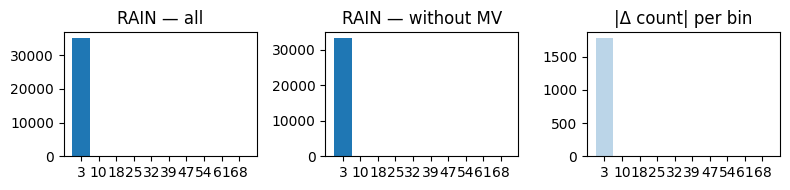

missingness  wd
NE     7.023346
ENE    5.037975
SW     5.537362
E      3.757669
NNE    6.094070
WSW    5.560579
SSW    4.623451
N      6.437561
NW     4.193548
ESE    3.028538
NNW    5.978603
SE     3.653990
S      2.914110
W      3.586678
WNW    3.542234
SSE    3.522505
NaN    1.234568
Name: count, dtype: float64


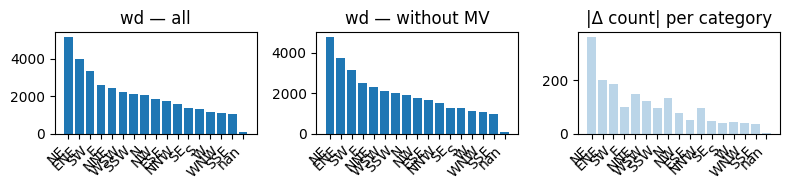

[5.41560743 4.89292088 4.79968267 4.82818617 5.31073446 3.7037037
 3.84615385 5.88235294 0.         0.        ]


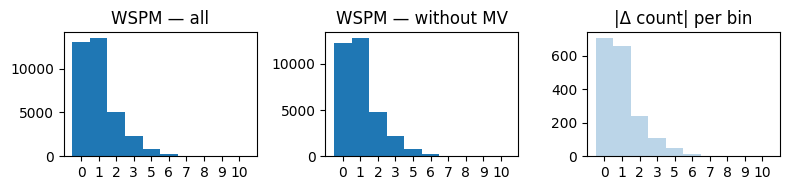

missingness  station
Aotizhongxin    5.065024
Name: count, dtype: float64


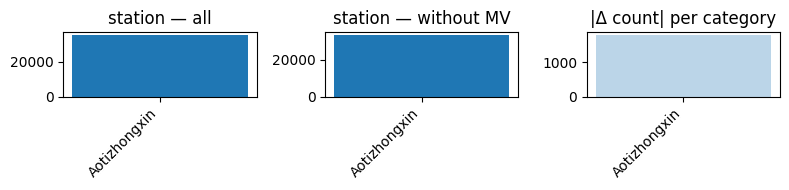

In [78]:
diagnose_mv(df, 'CO')

[7.69335512        nan 6.81506849        nan        nan 2.9109589
        nan 3.17622951        nan 1.62429379]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


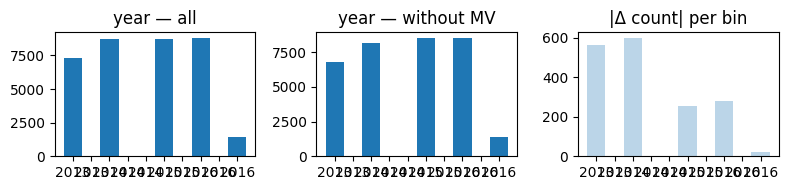

[ 2.46132208  2.75537634  5.41666667  3.52822581  3.36805556  2.95698925
  2.15053763  3.92361111  4.40188172 12.68784153]


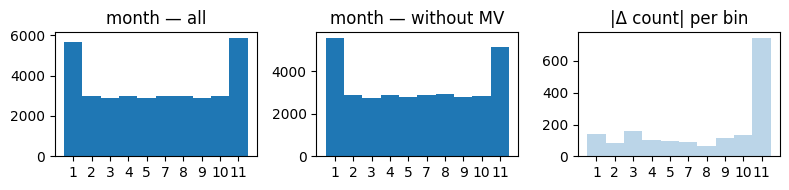

[4.74537037 3.29861111 3.67476852 4.31134259 4.51388889 3.73263889
 6.68402778 5.6712963  7.08912037 5.25252525]


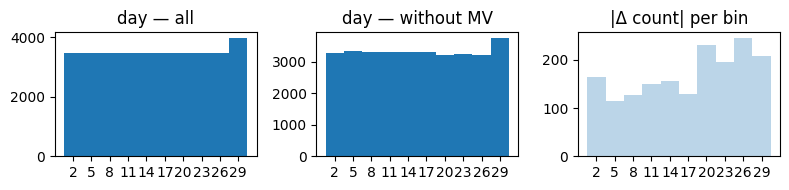

[ 4.01551449 16.80355921  4.48323066  4.01551449  3.86721424  3.79876797
  3.65046772  3.35386721  3.7303217   3.51357518]


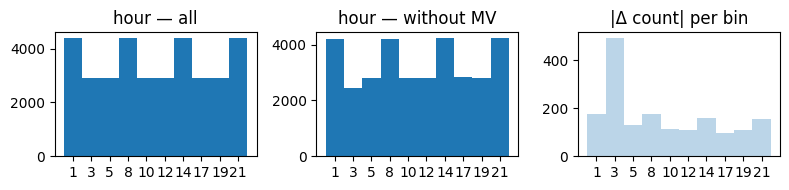

[2.76093689 3.93521617 4.23387097 2.5462963  2.54237288 6.14035088
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


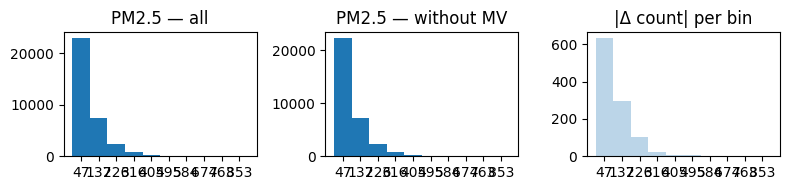

[ 2.62015504  3.96663954  4.12312906  1.98198198  2.5974026   2.98507463
  2.22222222 11.11111111  0.          0.        ]


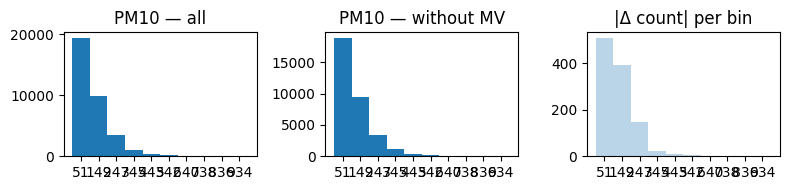

[2.68306891 3.85500575 5.81280788 1.91082803 1.72413793 0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


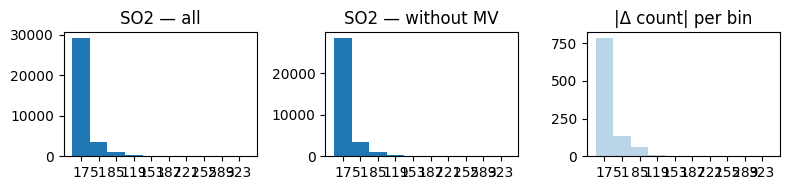

[1.47365978 2.35081374 4.14312618 4.1723356  4.61630695 2.34899329
 0.97087379 0.         0.         0.        ]


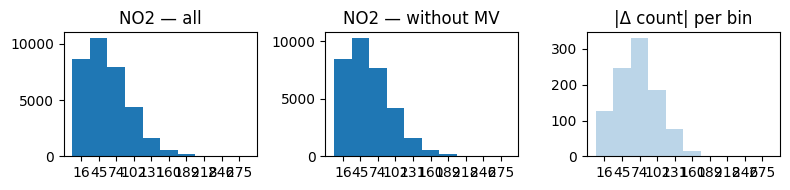

[1.75614651 2.82319877 4.51590831 4.50592885 1.38674884 2.22222222
 1.77514793 1.8018018  1.5625     0.        ]


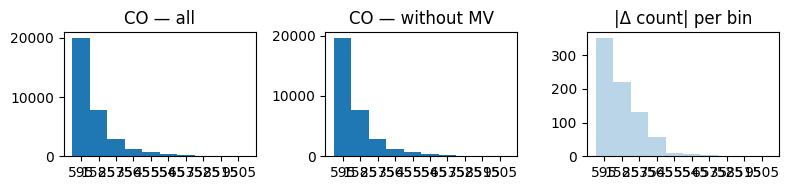

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


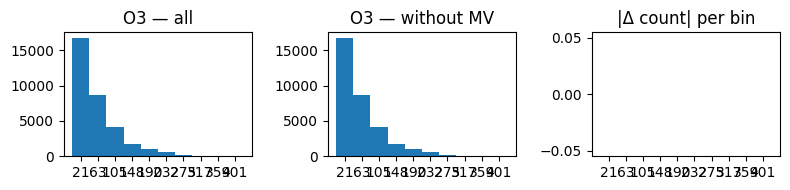

[3.03030303 6.63043478 7.60099958 6.74567001 6.20062246 4.78289619
 3.88516149 2.44749175 1.98602427 0.5952381 ]


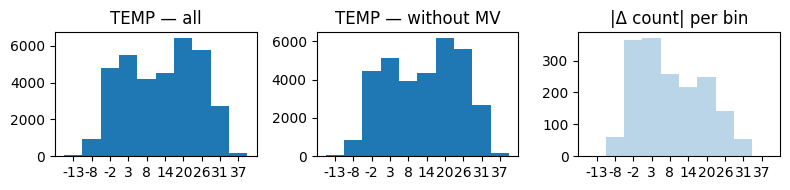

[2.85714286 2.99263352 3.44040723 2.49712502 4.14683889 7.74914399
 7.42179911 6.0845756  4.51911935 3.84615385]


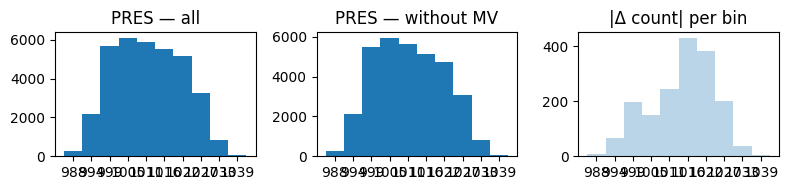

[5.26315789 4.34131737 4.93962678 6.55658086 5.55896178 6.3934061
 7.33988966 2.6080335  3.38983051 2.68317853]


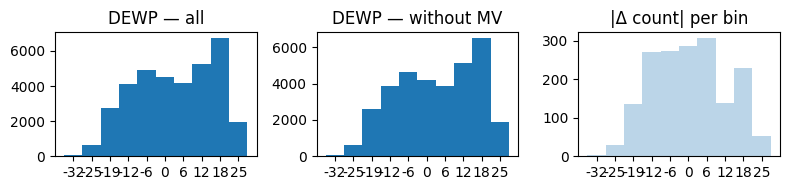

[ 4.91179918  0.          0.          0.         33.33333333  0.
  0.                 nan         nan  0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


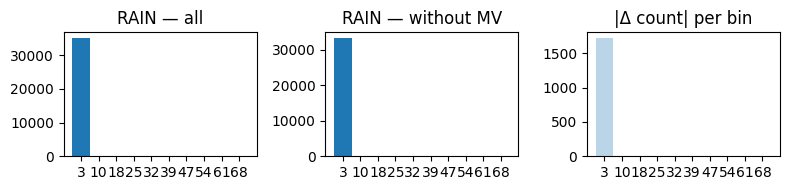

missingness  wd
NE     6.731518
ENE    5.518987
SW     3.959512
E      4.869632
NNE    5.030675
WSW    4.520796
SSW    3.956149
N      5.324298
NW     3.924731
ESE    3.610949
NNW    6.104468
SE     3.653990
S      3.527607
W      5.380017
WNW    4.813806
SSE    3.033268
NaN    6.172840
Name: count, dtype: float64


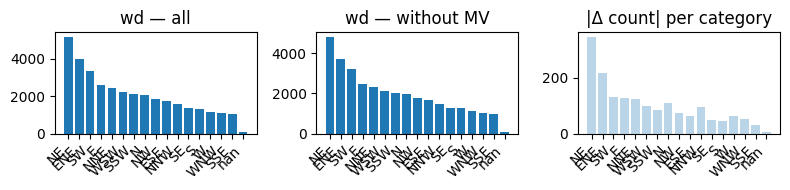

[6.50181034 4.16418798 3.84767949 3.30578512 3.95480226 2.69360269
 2.56410256 0.         0.         0.        ]


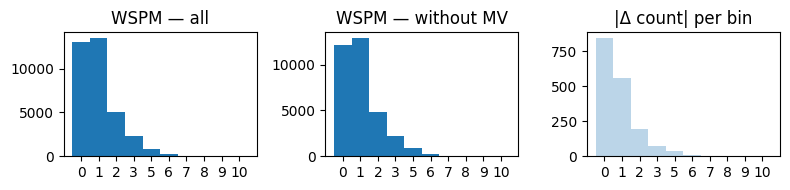

missingness  station
Aotizhongxin    4.902464
Name: count, dtype: float64


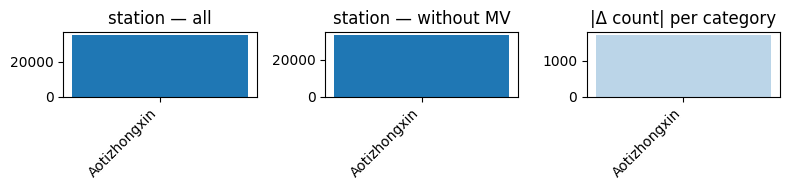

In [79]:
diagnose_mv(df, 'O3')

[0.                nan 0.                nan        nan 0.02283105
        nan 0.07969035        nan 0.77683616]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


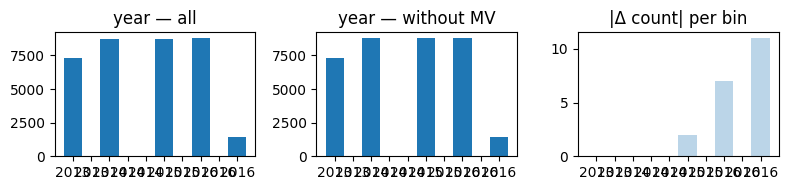

[0.22855134 0.         0.         0.         0.         0.
 0.         0.24305556 0.         0.        ]


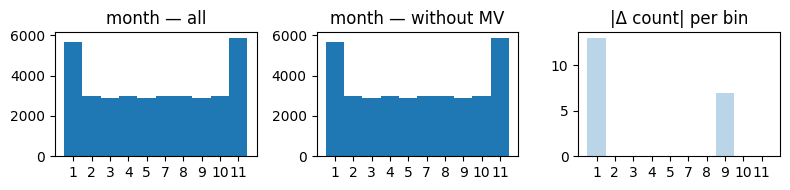

[0.         0.         0.         0.05787037 0.02893519 0.02893519
 0.17361111 0.         0.28935185 0.        ]


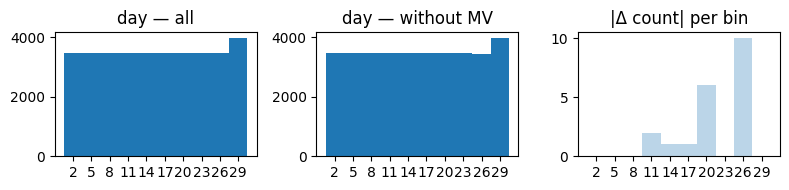

[0.02281542 0.06844627 0.06844627 0.09126169 0.         0.03422313
 0.06844627 0.03422313 0.1026694  0.06844627]


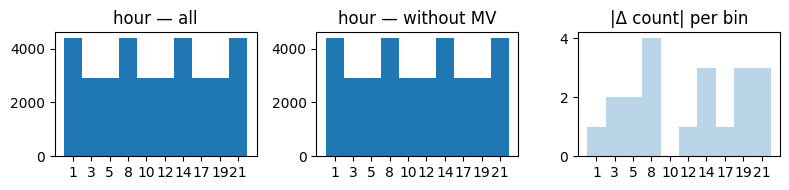

[0.03925503 0.13385089 0.04032258 0.         0.         0.
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


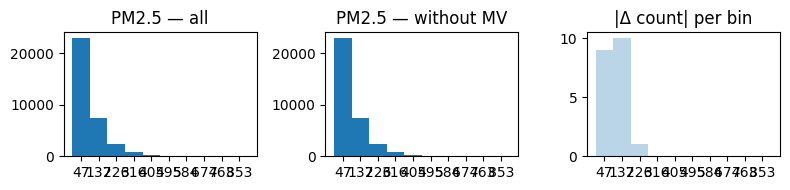

[0.05167959 0.10170871 0.         0.         0.         0.
 0.         0.         0.         0.        ]


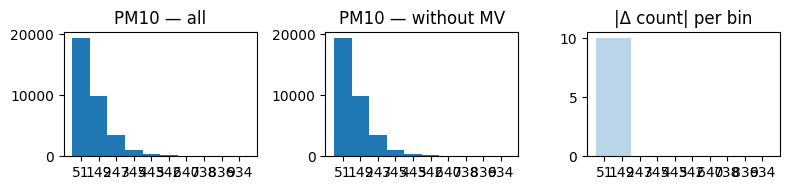

[0.0651064 0.0287687 0.        0.        0.        0.        0.
       nan       nan 0.       ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


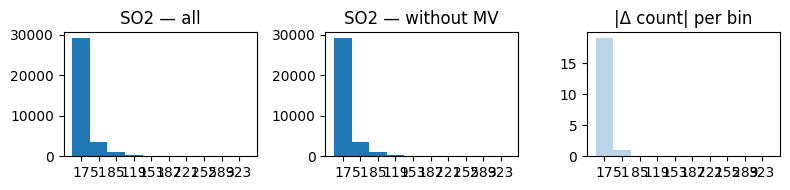

[0.0580181  0.05710479 0.08788449 0.04535147 0.         0.
 0.         0.         0.         0.        ]


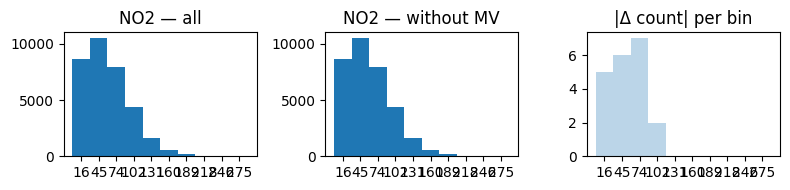

[0.04014049 0.07664793 0.13684571 0.15810277 0.         0.
 0.         0.         0.         0.        ]


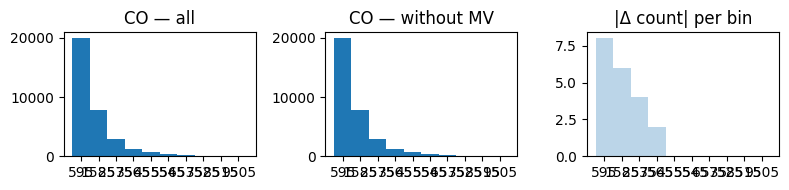

[0.03588088 0.09246417 0.1197318  0.         0.0923361  0.
 0.         0.         0.         0.        ]


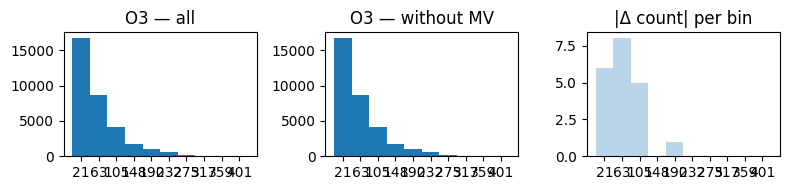

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


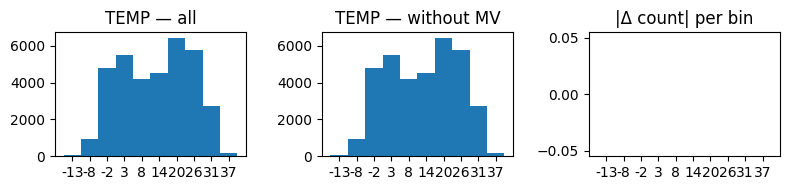

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


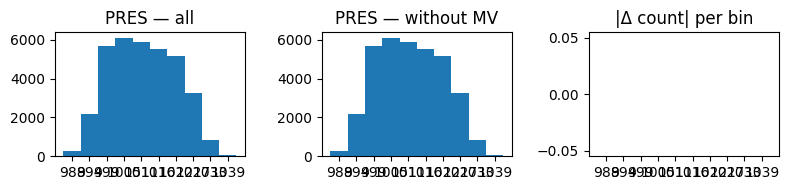

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


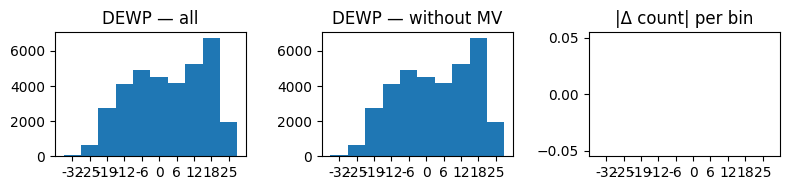

[ 0.  0.  0.  0.  0.  0.  0. nan nan  0.]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


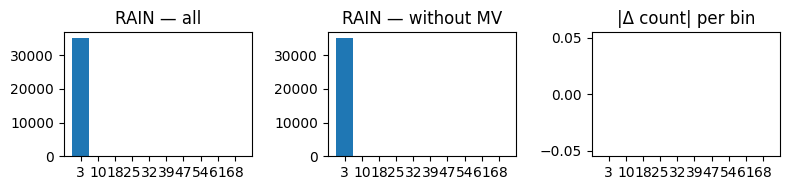

missingness  wd
NE      0.019455
ENE     0.000000
SW      0.089312
E       0.000000
NNE     0.000000
WSW     0.000000
SSW     0.000000
N       0.000000
NW      0.107527
ESE     0.000000
NNW     0.000000
SE      0.000000
S       0.000000
W       0.000000
WNW     0.000000
SSE     0.000000
NaN    17.283951
Name: count, dtype: float64


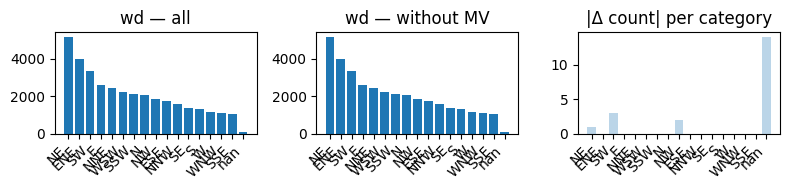

[0.00770357 0.00743605 0.0595002  0.         0.11299435 0.
 0.         0.         0.         0.        ]


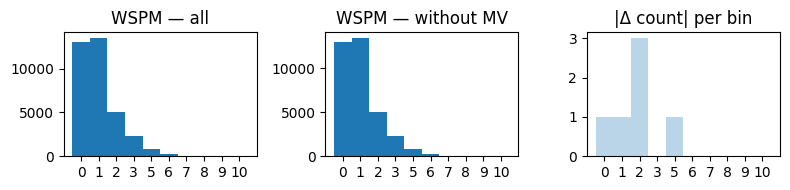

missingness  station
Aotizhongxin    0.057039
Name: count, dtype: float64


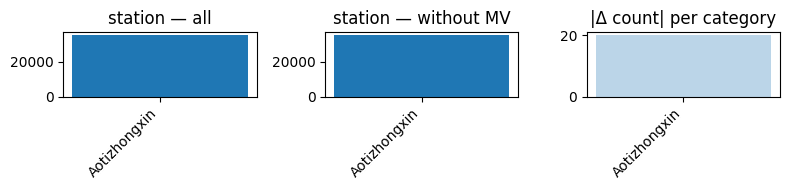

In [80]:
diagnose_mv(df, 'TEMP')

[0.                nan 0.                nan        nan 0.02283105
        nan 0.07969035        nan 0.77683616]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


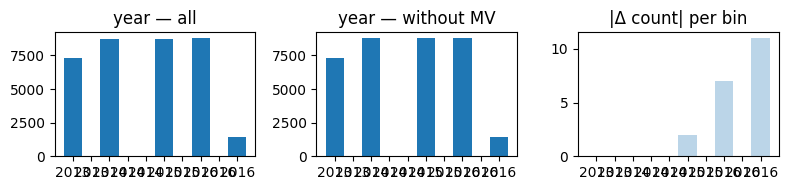

[0.22855134 0.         0.         0.         0.         0.
 0.         0.24305556 0.         0.        ]


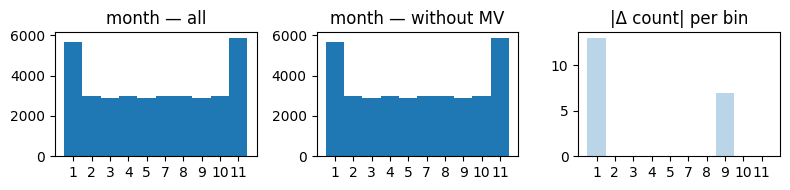

[0.         0.         0.         0.05787037 0.02893519 0.02893519
 0.17361111 0.         0.28935185 0.        ]


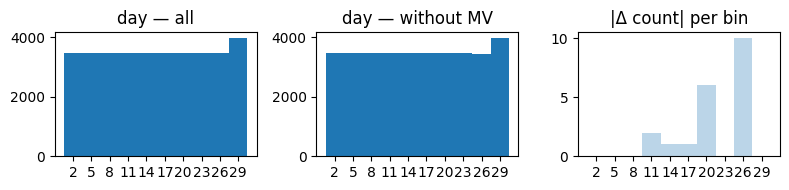

[0.02281542 0.06844627 0.06844627 0.09126169 0.         0.03422313
 0.06844627 0.03422313 0.1026694  0.06844627]


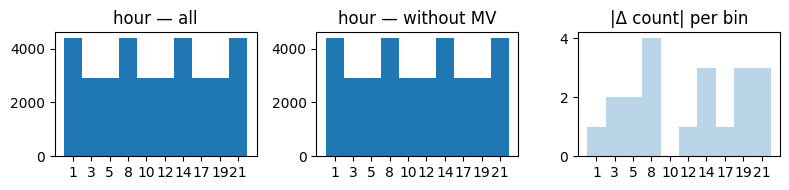

[0.03925503 0.13385089 0.04032258 0.         0.         0.
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


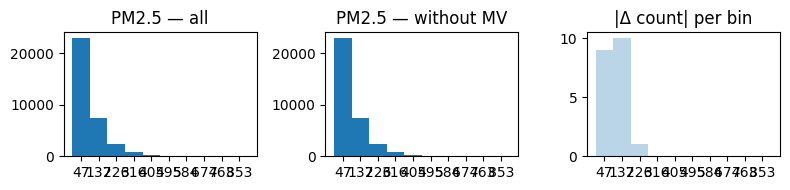

[0.05167959 0.10170871 0.         0.         0.         0.
 0.         0.         0.         0.        ]


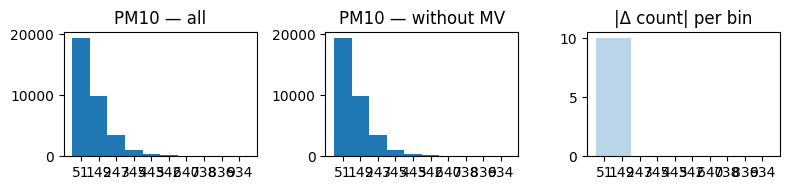

[0.0651064 0.0287687 0.        0.        0.        0.        0.
       nan       nan 0.       ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


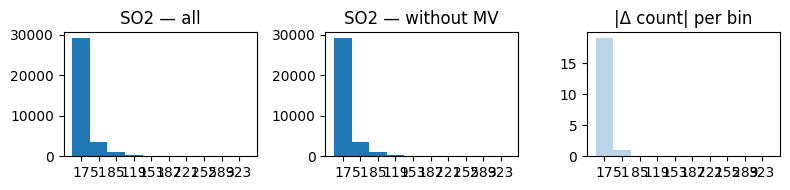

[0.0580181  0.05710479 0.08788449 0.04535147 0.         0.
 0.         0.         0.         0.        ]


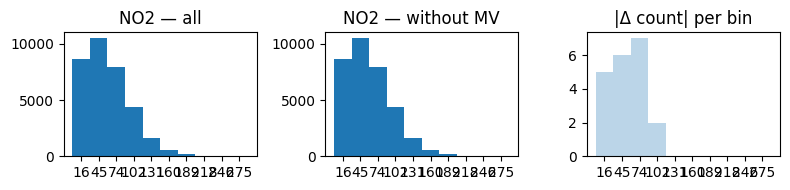

[0.04014049 0.07664793 0.13684571 0.15810277 0.         0.
 0.         0.         0.         0.        ]


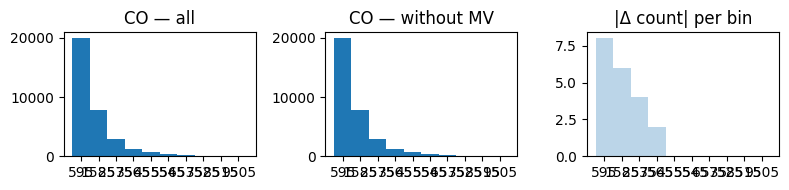

[0.03588088 0.09246417 0.1197318  0.         0.0923361  0.
 0.         0.         0.         0.        ]


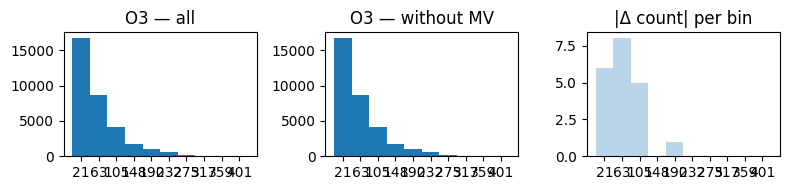

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


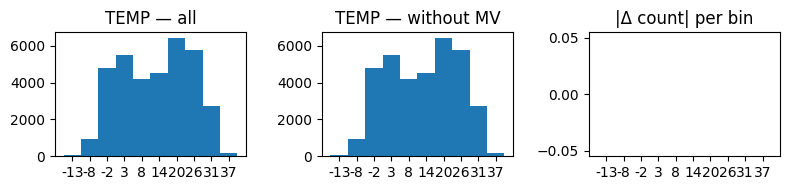

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


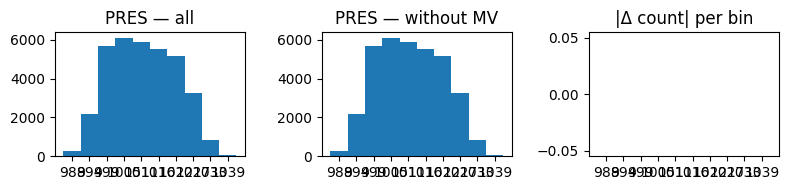

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


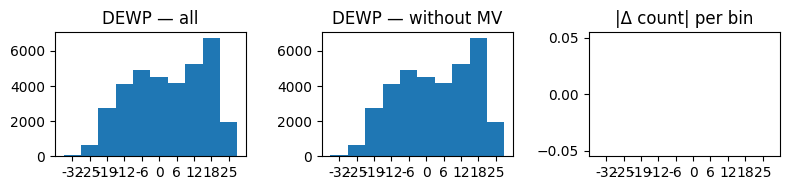

[ 0.  0.  0.  0.  0.  0.  0. nan nan  0.]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


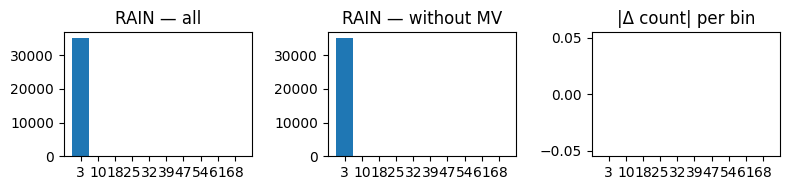

missingness  wd
NE      0.019455
ENE     0.000000
SW      0.089312
E       0.000000
NNE     0.000000
WSW     0.000000
SSW     0.000000
N       0.000000
NW      0.107527
ESE     0.000000
NNW     0.000000
SE      0.000000
S       0.000000
W       0.000000
WNW     0.000000
SSE     0.000000
NaN    17.283951
Name: count, dtype: float64


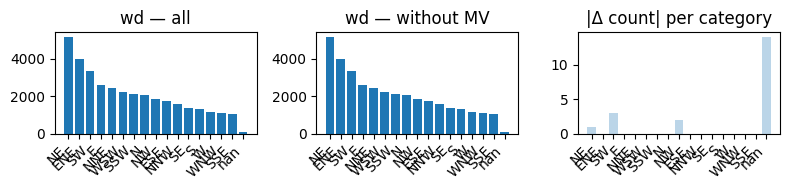

[0.00770357 0.00743605 0.0595002  0.         0.11299435 0.
 0.         0.         0.         0.        ]


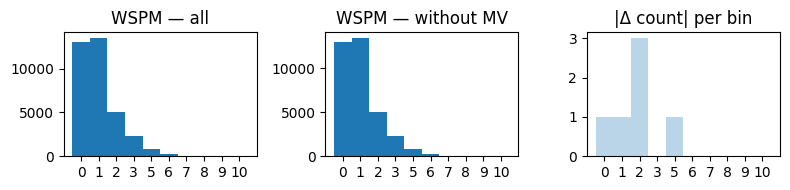

missingness  station
Aotizhongxin    0.057039
Name: count, dtype: float64


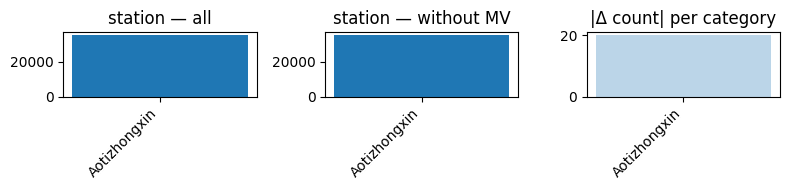

In [81]:
diagnose_mv(df, 'PRES')

[0.                nan 0.                nan        nan 0.02283105
        nan 0.07969035        nan 0.77683616]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


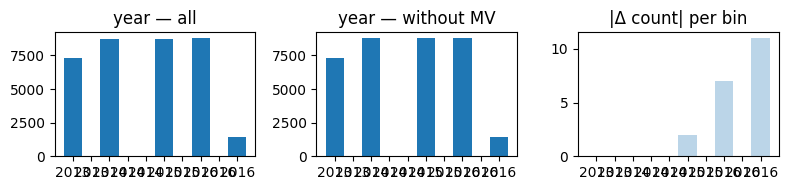

[0.22855134 0.         0.         0.         0.         0.
 0.         0.24305556 0.         0.        ]


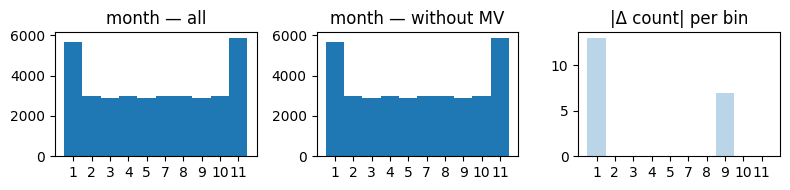

[0.         0.         0.         0.05787037 0.02893519 0.02893519
 0.17361111 0.         0.28935185 0.        ]


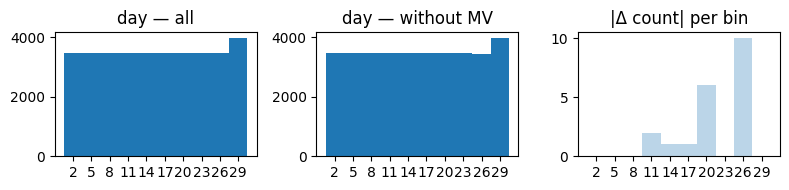

[0.02281542 0.06844627 0.06844627 0.09126169 0.         0.03422313
 0.06844627 0.03422313 0.1026694  0.06844627]


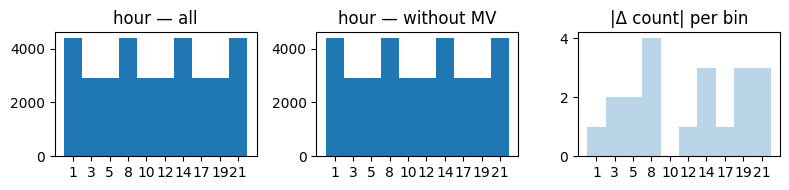

[0.03925503 0.13385089 0.04032258 0.         0.         0.
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


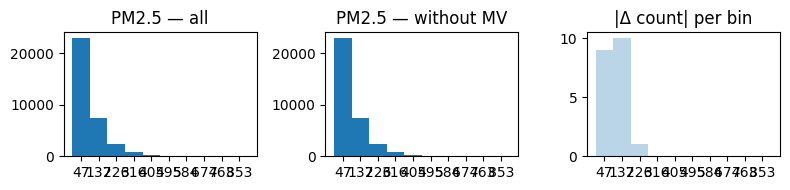

[0.05167959 0.10170871 0.         0.         0.         0.
 0.         0.         0.         0.        ]


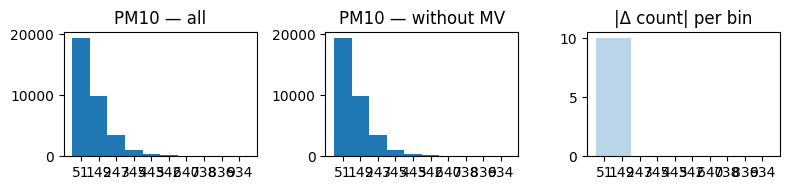

[0.0651064 0.0287687 0.        0.        0.        0.        0.
       nan       nan 0.       ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


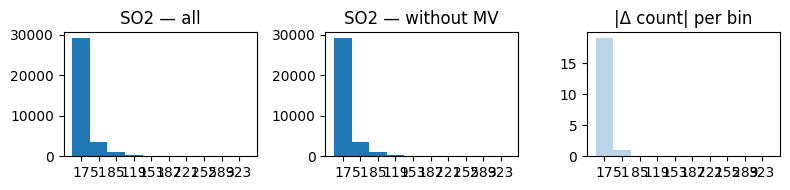

[0.0580181  0.05710479 0.08788449 0.04535147 0.         0.
 0.         0.         0.         0.        ]


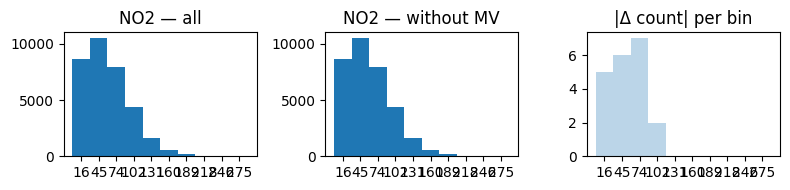

[0.04014049 0.07664793 0.13684571 0.15810277 0.         0.
 0.         0.         0.         0.        ]


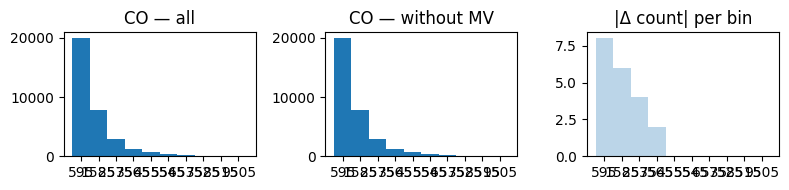

[0.03588088 0.09246417 0.1197318  0.         0.0923361  0.
 0.         0.         0.         0.        ]


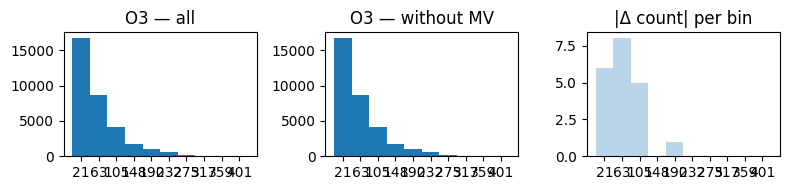

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


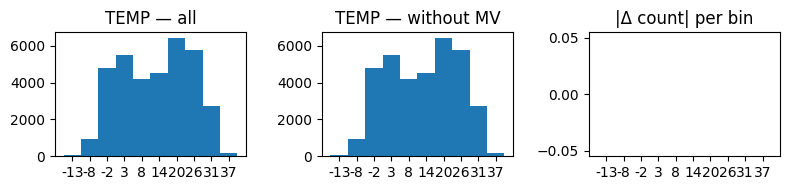

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


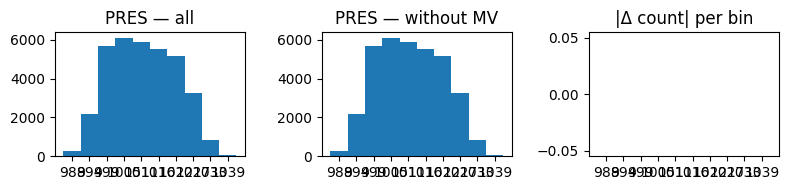

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


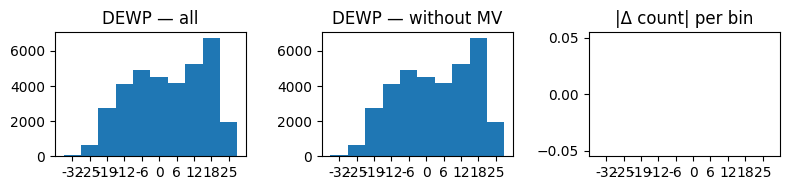

[ 0.  0.  0.  0.  0.  0.  0. nan nan  0.]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


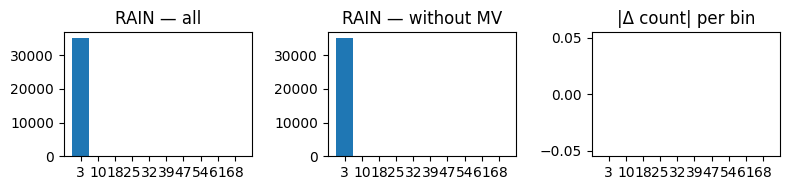

missingness  wd
NE      0.019455
ENE     0.000000
SW      0.089312
E       0.000000
NNE     0.000000
WSW     0.000000
SSW     0.000000
N       0.000000
NW      0.107527
ESE     0.000000
NNW     0.000000
SE      0.000000
S       0.000000
W       0.000000
WNW     0.000000
SSE     0.000000
NaN    17.283951
Name: count, dtype: float64


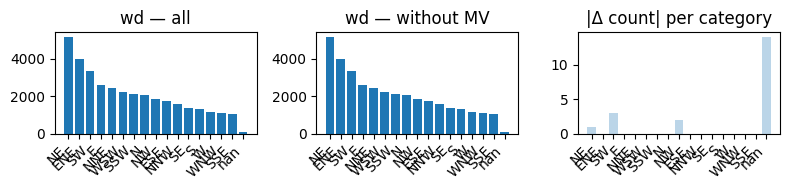

[0.00770357 0.00743605 0.0595002  0.         0.11299435 0.
 0.         0.         0.         0.        ]


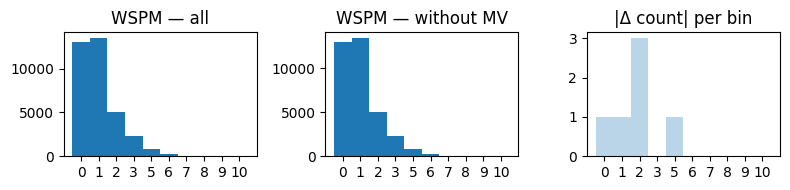

missingness  station
Aotizhongxin    0.057039
Name: count, dtype: float64


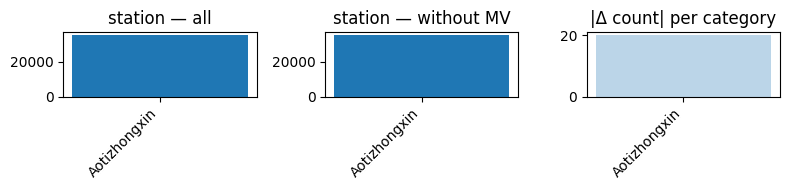

In [82]:
diagnose_mv(df, 'DEWP')

[0.                nan 0.                nan        nan 0.02283105
        nan 0.07969035        nan 0.77683616]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


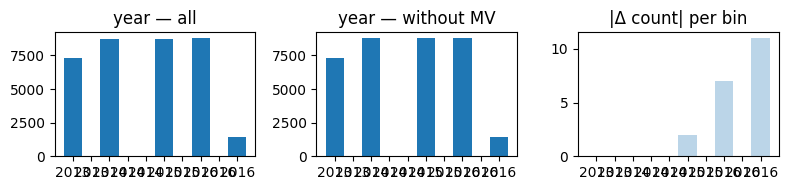

[0.22855134 0.         0.         0.         0.         0.
 0.         0.24305556 0.         0.        ]


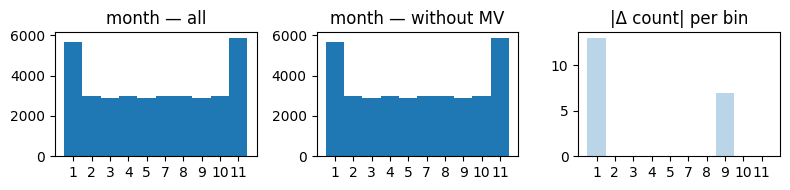

[0.         0.         0.         0.05787037 0.02893519 0.02893519
 0.17361111 0.         0.28935185 0.        ]


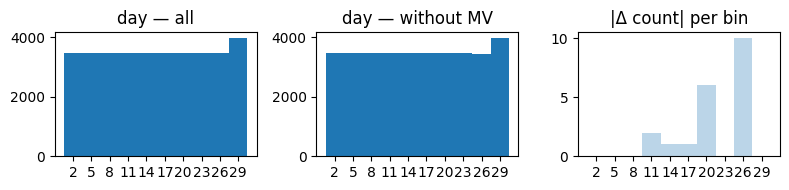

[0.02281542 0.06844627 0.06844627 0.09126169 0.         0.03422313
 0.06844627 0.03422313 0.1026694  0.06844627]


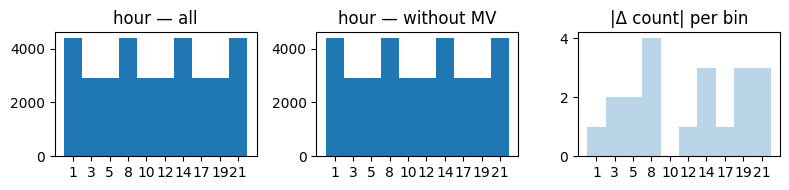

[0.03925503 0.13385089 0.04032258 0.         0.         0.
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


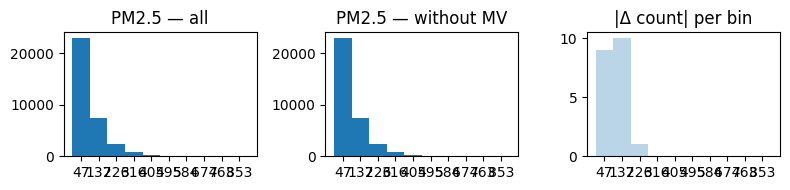

[0.05167959 0.10170871 0.         0.         0.         0.
 0.         0.         0.         0.        ]


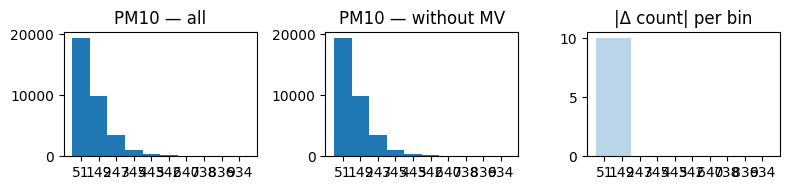

[0.0651064 0.0287687 0.        0.        0.        0.        0.
       nan       nan 0.       ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


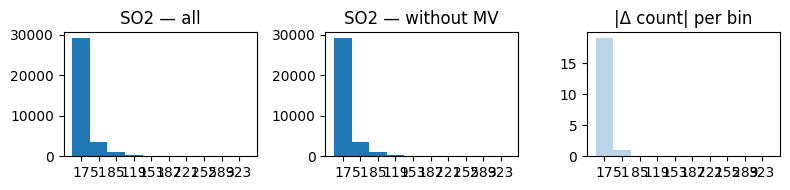

[0.0580181  0.05710479 0.08788449 0.04535147 0.         0.
 0.         0.         0.         0.        ]


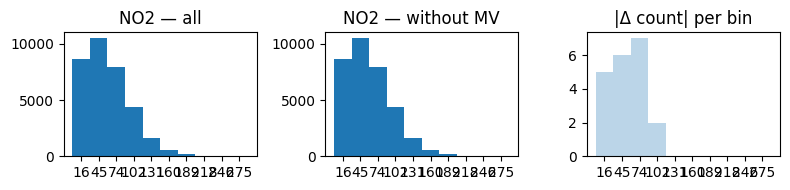

[0.04014049 0.07664793 0.13684571 0.15810277 0.         0.
 0.         0.         0.         0.        ]


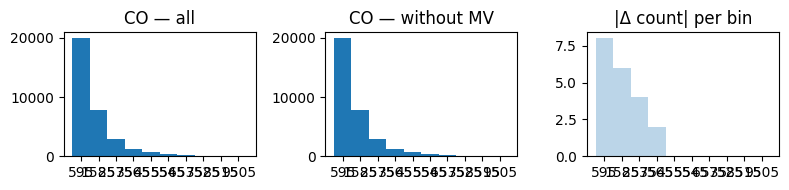

[0.03588088 0.09246417 0.1197318  0.         0.0923361  0.
 0.         0.         0.         0.        ]


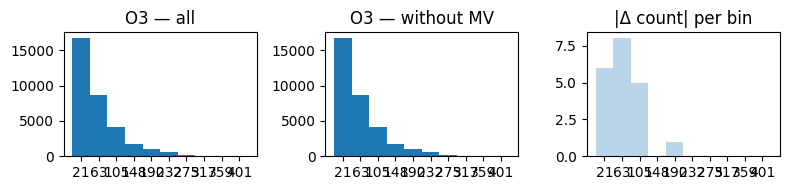

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


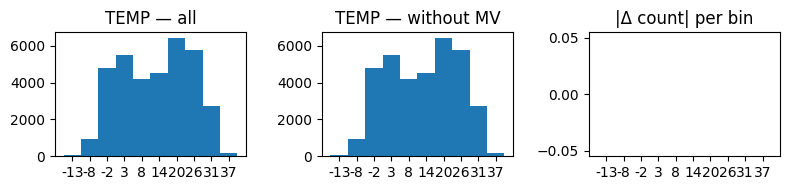

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


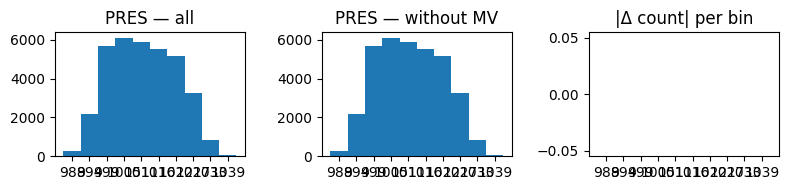

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


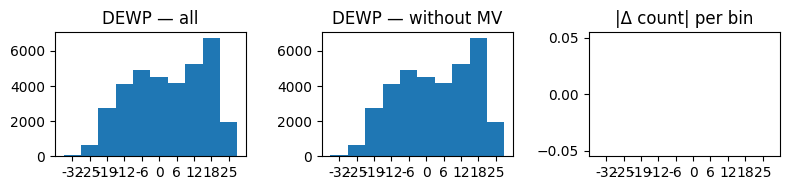

[ 0.  0.  0.  0.  0.  0.  0. nan nan  0.]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


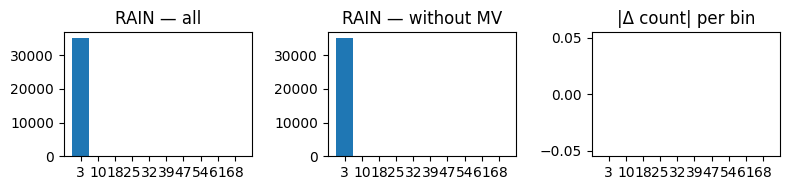

missingness  wd
NE      0.019455
ENE     0.000000
SW      0.089312
E       0.000000
NNE     0.000000
WSW     0.000000
SSW     0.000000
N       0.000000
NW      0.107527
ESE     0.000000
NNW     0.000000
SE      0.000000
S       0.000000
W       0.000000
WNW     0.000000
SSE     0.000000
NaN    17.283951
Name: count, dtype: float64


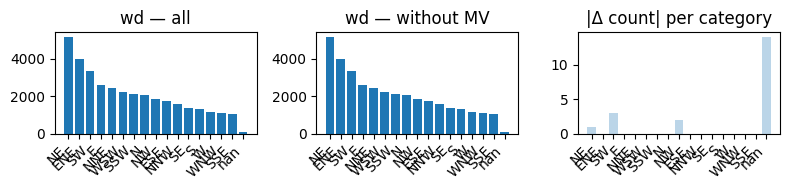

[0.00770357 0.00743605 0.0595002  0.         0.11299435 0.
 0.         0.         0.         0.        ]


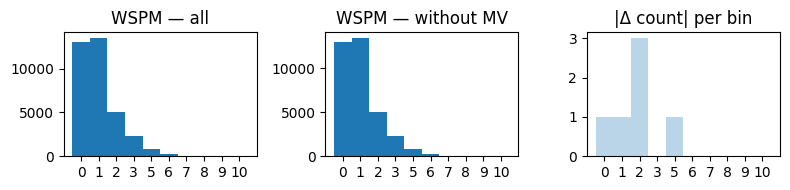

missingness  station
Aotizhongxin    0.057039
Name: count, dtype: float64


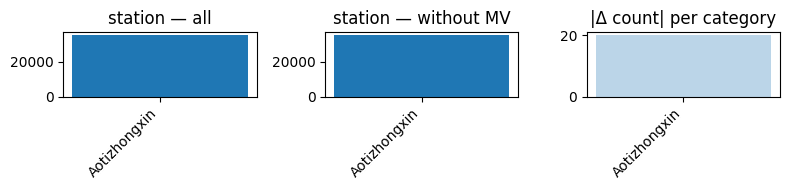

In [83]:
diagnose_mv(df, 'RAIN')

[0.01361656        nan 0.02283105        nan        nan 0.06849315
        nan 0.46675774        nan 2.18926554]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


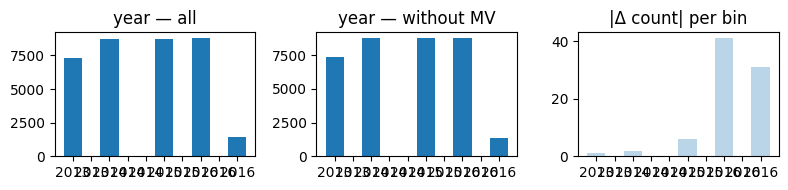

[0.59774965 0.03360215 0.         0.0672043  0.         0.10080645
 0.03360215 0.625      0.40322581 0.17076503]


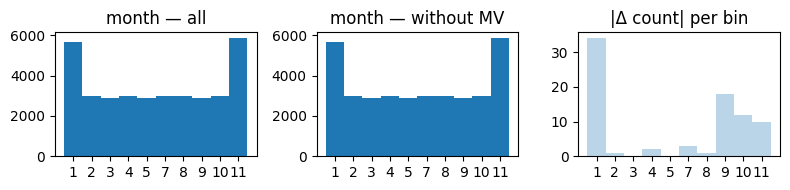

[0.08680556 0.14467593 0.14467593 0.34722222 0.2025463  0.2025463
 0.17361111 0.28935185 0.54976852 0.17676768]


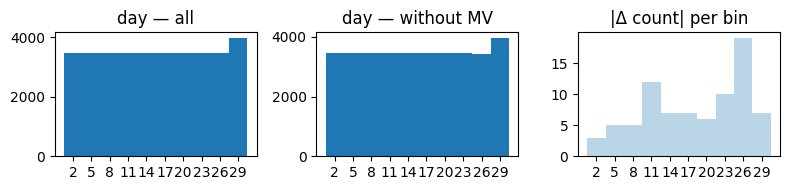

[0.31941593 0.47912389 0.37645448 0.13689254 0.03422313 0.03422313
 0.09126169 0.06844627 0.44490075 0.34223135]


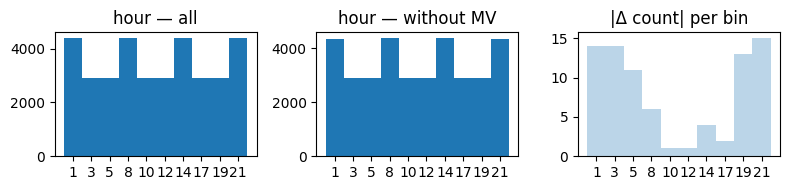

[0.21372181 0.25431669 0.44354839 0.23148148 0.         0.
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


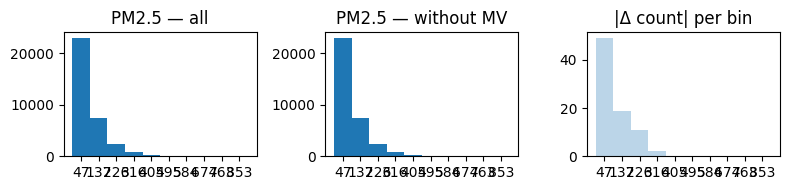

[0.20155039 0.29495525 0.31064671 0.18018018 0.         0.
 0.         0.         0.         0.        ]


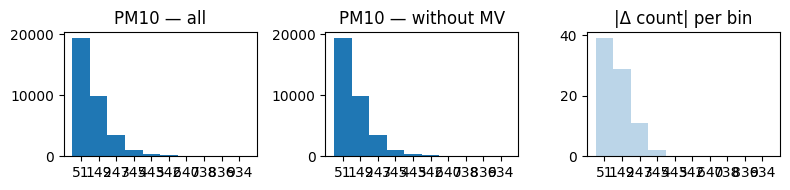

[0.24329233 0.287687   0.         0.         0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


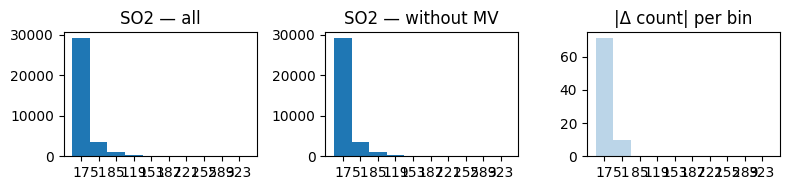

[ 0.09282896  0.12372704  0.42686755  0.38548753  0.29976019  0.33557047
  0.          0.         10.         14.28571429]


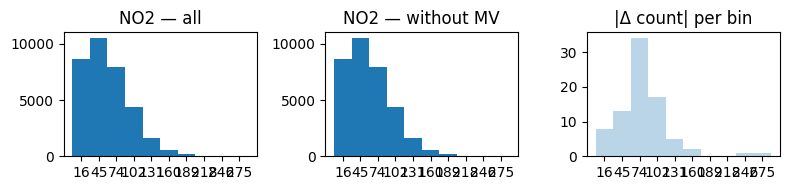

[0.17059709 0.31936638 0.20526856 0.86956522 0.46224961 0.31746032
 0.         0.         0.         0.        ]


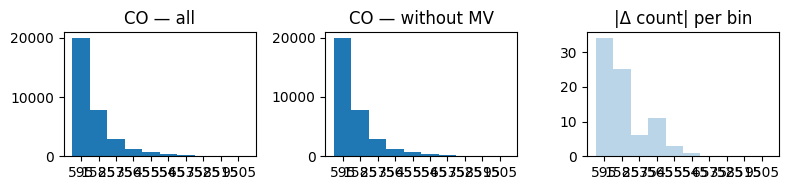

[0.287047   0.20804438 0.2394636  0.         0.         0.
 0.         0.         0.         0.        ]


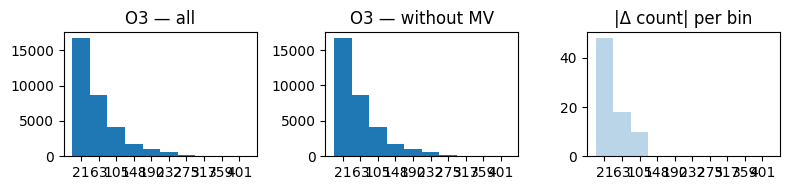

[0.         0.54347826 0.4789671  0.18231541 0.2633469  0.11020498
 0.15603058 0.05207429 0.         0.        ]


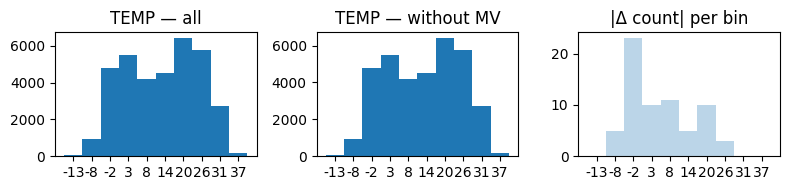

[0.         0.09208103 0.05265929 0.04928536 0.25492862 0.25229771
 0.34971828 0.2738059  0.34762457 0.        ]


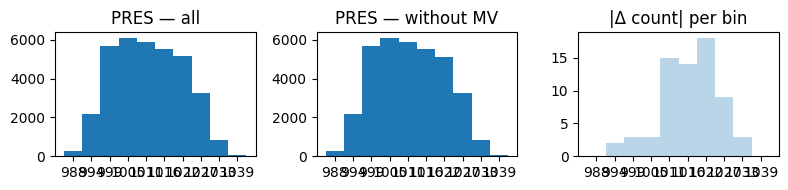

[0.         0.         0.18294914 0.26711996 0.36787247 0.08910671
 0.28783881 0.15229393 0.11894142 0.05159959]


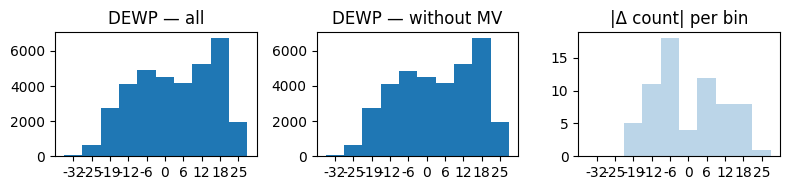

[0.19155445 0.         0.         0.         0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


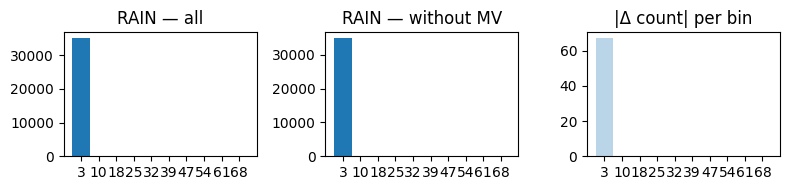

missingness  wd
E        0.0
ENE      0.0
ESE      0.0
N        0.0
NE       0.0
NNE      0.0
NNW      0.0
NW       0.0
S        0.0
SE       0.0
SSE      0.0
SSW      0.0
SW       0.0
W        0.0
WNW      0.0
WSW      0.0
NaN    100.0
Name: count, dtype: float64


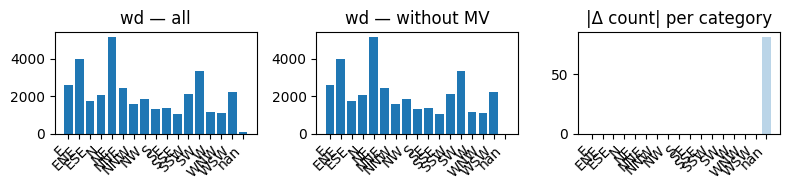

[0.49302827 0.         0.0198334  0.04349717 0.         0.33670034
 0.         0.         0.         0.        ]


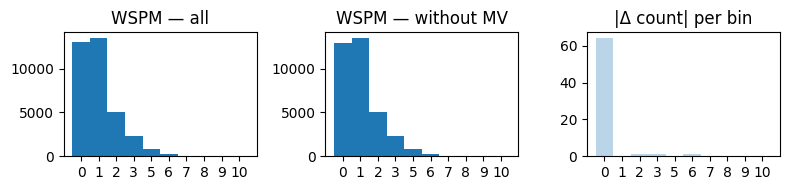

missingness  station
Aotizhongxin    0.231006
Name: count, dtype: float64


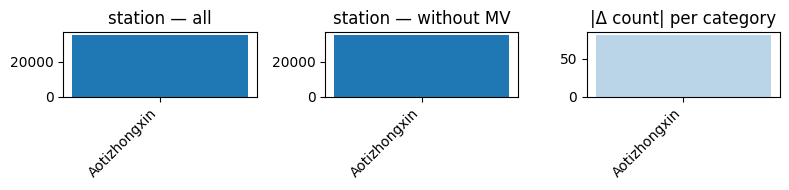

In [84]:
diagnose_mv(df, 'wd')

[0.                nan 0.                nan        nan 0.02283105
        nan 0.05692168        nan 0.49435028]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


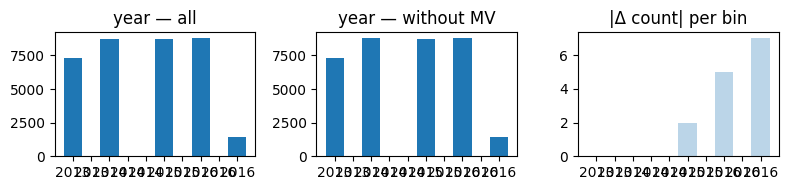

[0.15822785 0.         0.         0.         0.         0.
 0.         0.17361111 0.         0.        ]


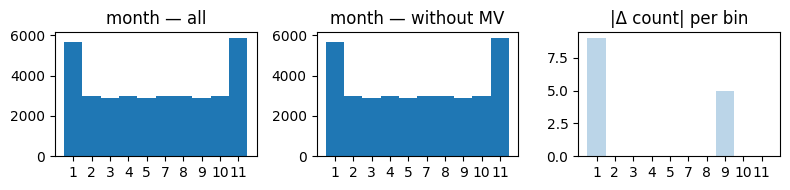

[0.         0.         0.         0.         0.         0.02893519
 0.14467593 0.         0.23148148 0.        ]


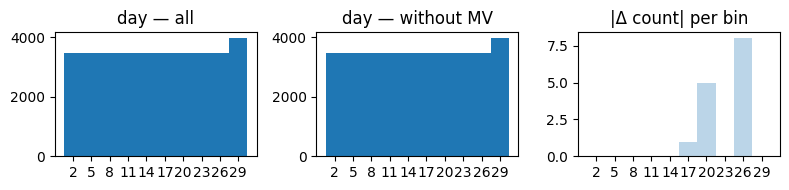

[0.         0.06844627 0.06844627 0.04563085 0.         0.03422313
 0.02281542 0.         0.1026694  0.06844627]


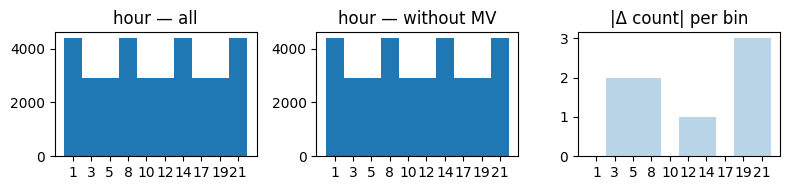

[0.01744668 0.1204658  0.04032258 0.         0.         0.
 0.         0.                nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


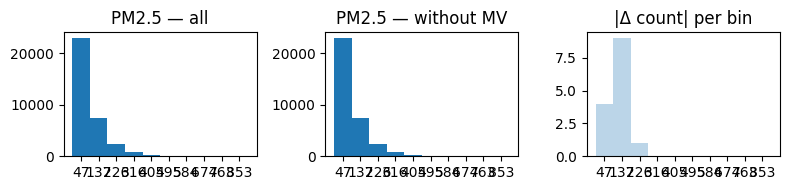

[0.02583979 0.09153784 0.         0.         0.         0.
 0.         0.         0.         0.        ]


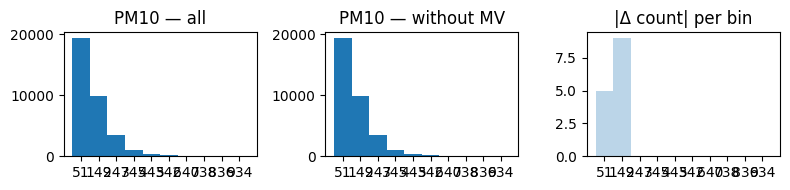

[0.04454648 0.0287687  0.         0.         0.         0.
 0.                nan        nan 0.        ]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


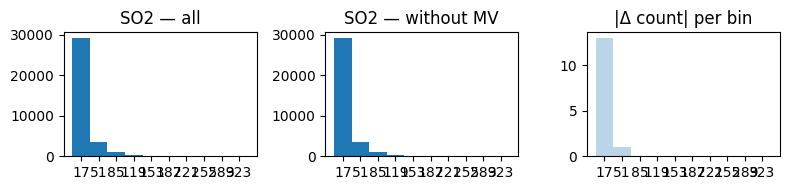

[0.03481086 0.02855239 0.07532957 0.04535147 0.         0.
 0.         0.         0.         0.        ]


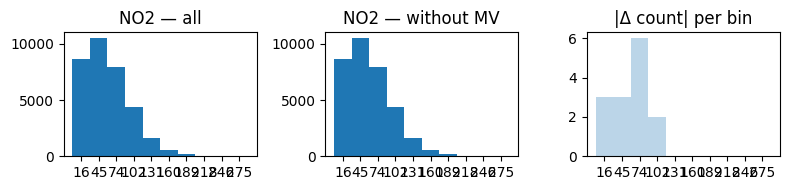

[0.01505268 0.07664793 0.10263428 0.15810277 0.         0.
 0.         0.         0.         0.        ]


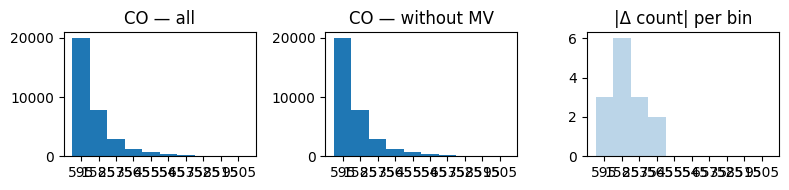

[0.02990073 0.05779011 0.09578544 0.         0.         0.
 0.         0.         0.         0.        ]


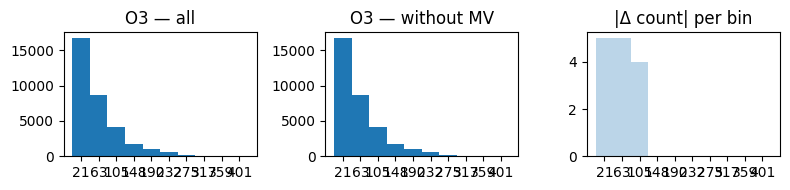

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


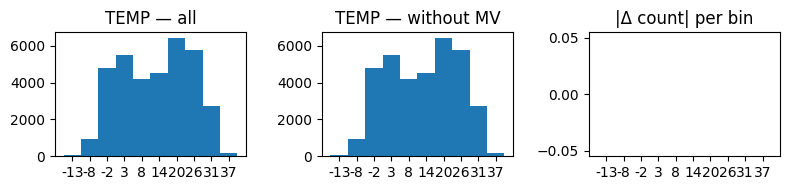

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


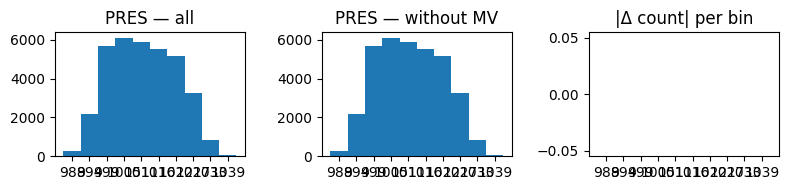

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


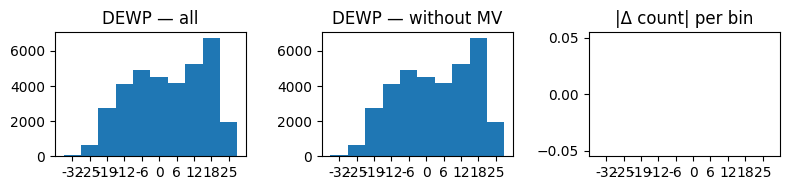

[ 0.  0.  0.  0.  0.  0.  0. nan nan  0.]


C:\Users\yohan\AppData\Local\Temp\ipykernel_7188\1300816577.py:15: RuntimeWarning: invalid value encountered in divide
  missingness= diff/countsAll


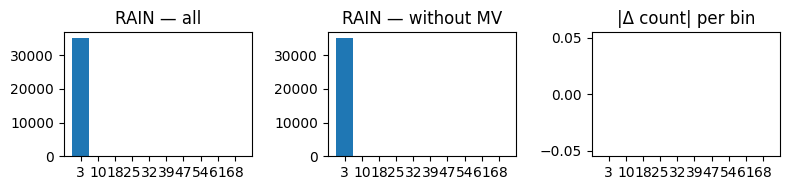

missingness  wd
NE      0.000000
ENE     0.000000
SW      0.000000
E       0.000000
NNE     0.000000
WSW     0.000000
SSW     0.000000
N       0.000000
NW      0.000000
ESE     0.000000
NNW     0.000000
SE      0.000000
S       0.000000
W       0.000000
WNW     0.000000
SSE     0.000000
NaN    17.283951
Name: count, dtype: float64


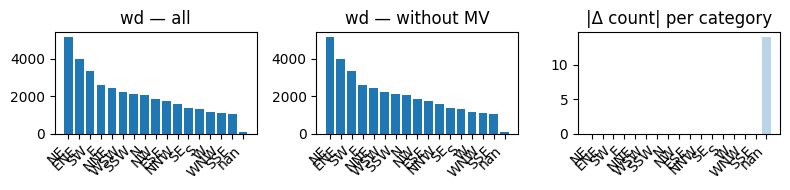

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


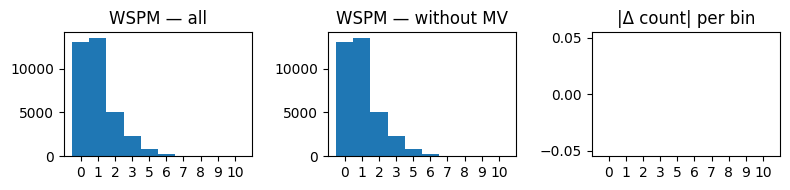

missingness  station
Aotizhongxin    0.039927
Name: count, dtype: float64


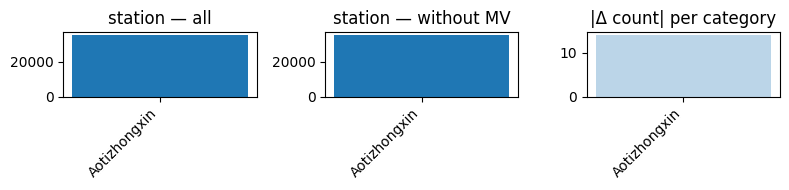

In [85]:
diagnose_mv(df, 'WSPM')

In [86]:
def t_test():

_IncompleteInputError: incomplete input (4073003215.py, line 1)